In [ ]:
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


98%
**bold text**

In [ ]:
# Install required packages
!pip install -q efficientnet_pytorch tqdm

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime (only if it doesn't already exist)
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model
model = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation functions with tqdm
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.7 MB/s eta 0:00:00
Using device: cuda


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 242MB/s]


Loaded pretrained weights for efficientnet-b0


Epoch [1/10] Train Loss: 0.4445 Train Acc: 0.8576 Val Loss: 2.3169 Val Acc: 0.6107


Epoch [2/10] Train Loss: 0.2169 Train Acc: 0.9344 Val Loss: 0.5855 Val Acc: 0.8443


Epoch [3/10] Train Loss: 0.0989 Train Acc: 0.9703 Val Loss: 0.2007 Val Acc: 0.9262


Epoch [4/10] Train Loss: 0.0953 Train Acc: 0.9713 Val Loss: 0.2151 Val Acc: 0.9467


Epoch [5/10] Train Loss: 0.0846 Train Acc: 0.9764 Val Loss: 0.3521 Val Acc: 0.9385


Epoch [6/10] Train Loss: 0.0847 Train Acc: 0.9734 Val Loss: 0.1635 Val Acc: 0.9508


Epoch [7/10] Train Loss: 0.1124 Train Acc: 0.9703 Val Loss: 0.2128 Val Acc: 0.9467


Epoch [8/10] Train Loss: 0.0739 Train Acc: 0.9805 Val Loss: 0.1597 Val Acc: 0.9426


Epoch [9/10] Train Loss: 0.0497 Train Acc: 0.9846 Val Loss: 0.1169 Val Acc: 0.9713


Epoch [10/10] Train Loss: 0.0433 Train Acc: 0.9857 Val Loss: 0.1593 Val Acc: 0.9508
Training complete.


Test Loss: 0.0664 Test Accuracy: 0.9853


# Running on Different MOdel

Using device: cuda
Loaded pretrained weights for efficientnet-b0


Epoch [1/10] Train Loss: 0.4445 Train Acc: 0.8576 Val Loss: 2.3194 Val Acc: 0.6107


Epoch [2/10] Train Loss: 0.2169 Train Acc: 0.9344 Val Loss: 0.5858 Val Acc: 0.8443


Epoch [3/10] Train Loss: 0.0989 Train Acc: 0.9703 Val Loss: 0.2007 Val Acc: 0.9262


Epoch [4/10] Train Loss: 0.0953 Train Acc: 0.9713 Val Loss: 0.2151 Val Acc: 0.9467


Epoch [5/10] Train Loss: 0.0846 Train Acc: 0.9764 Val Loss: 0.3522 Val Acc: 0.9385


Epoch [6/10] Train Loss: 0.0847 Train Acc: 0.9734 Val Loss: 0.1637 Val Acc: 0.9508


Epoch [7/10] Train Loss: 0.1124 Train Acc: 0.9703 Val Loss: 0.2131 Val Acc: 0.9467


Epoch [8/10] Train Loss: 0.0739 Train Acc: 0.9805 Val Loss: 0.1595 Val Acc: 0.9426


Epoch [9/10] Train Loss: 0.0496 Train Acc: 0.9846 Val Loss: 0.1169 Val Acc: 0.9713


Epoch [10/10] Train Loss: 0.0432 Train Acc: 0.9857 Val Loss: 0.1592 Val Acc: 0.9590
Training complete.


Test Loss: 0.0664 Test Accuracy: 0.9853


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       1.00      0.93      0.96        54
   Black Soil       1.00      0.99      1.00       116
    Clay soil       0.94      1.00      0.97        65
     Red soil       0.99      1.00      1.00       105

     accuracy                           0.99       340
    macro avg       0.98      0.98      0.98       340
 weighted avg       0.99      0.99      0.99       340



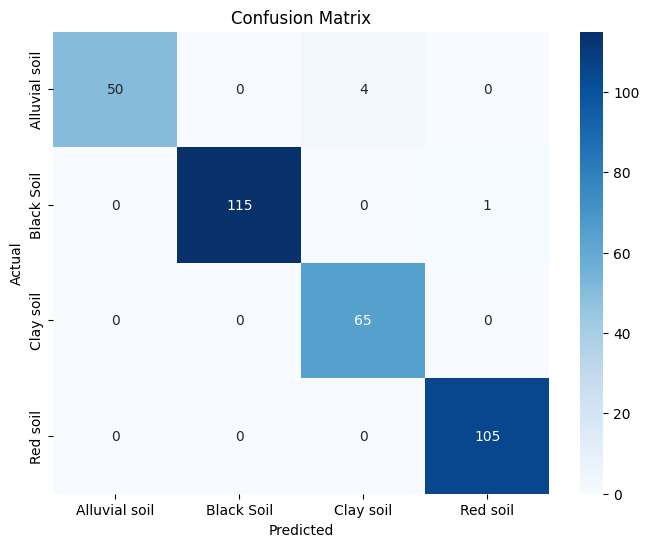

In [ ]:
# Install required packages
!pip install -q efficientnet_pytorch tqdm seaborn scikit-learn

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime (only if it doesn't already exist)
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model
model = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Using device: cuda


Epoch [1/10] Train Loss: 1.1688 Train Acc: 0.5400 Val Loss: 0.8899 Val Acc: 0.5697


Epoch [2/10] Train Loss: 0.9429 Train Acc: 0.5645 Val Loss: 0.9079 Val Acc: 0.6393


Epoch [3/10] Train Loss: 0.9346 Train Acc: 0.6209 Val Loss: 1.3468 Val Acc: 0.5984


Epoch [4/10] Train Loss: 1.1920 Train Acc: 0.5502 Val Loss: 1.0000 Val Acc: 0.6025


Epoch [5/10] Train Loss: 1.3526 Train Acc: 0.5092 Val Loss: 1.3333 Val Acc: 0.4508


Epoch [6/10] Train Loss: 1.3160 Train Acc: 0.4293 Val Loss: 1.2979 Val Acc: 0.4508


Epoch [7/10] Train Loss: 1.3079 Train Acc: 0.4293 Val Loss: 1.3016 Val Acc: 0.4508


Epoch [8/10] Train Loss: 1.3075 Train Acc: 0.4293 Val Loss: 1.2932 Val Acc: 0.4508


Epoch [9/10] Train Loss: 1.3072 Train Acc: 0.4293 Val Loss: 1.3008 Val Acc: 0.4508


Epoch [10/10] Train Loss: 1.3096 Train Acc: 0.4293 Val Loss: 1.2971 Val Acc: 0.4508
Training complete.


Test Loss: 0.8487 Test Accuracy: 0.6059


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.35      0.83      0.49        54
   Black Soil       0.86      0.51      0.64       116
    Clay soil       0.00      0.00      0.00        65
     Red soil       0.71      0.97      0.82       105

     accuracy                           0.61       340
    macro avg       0.48      0.58      0.49       340
 weighted avg       0.57      0.61      0.55       340



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


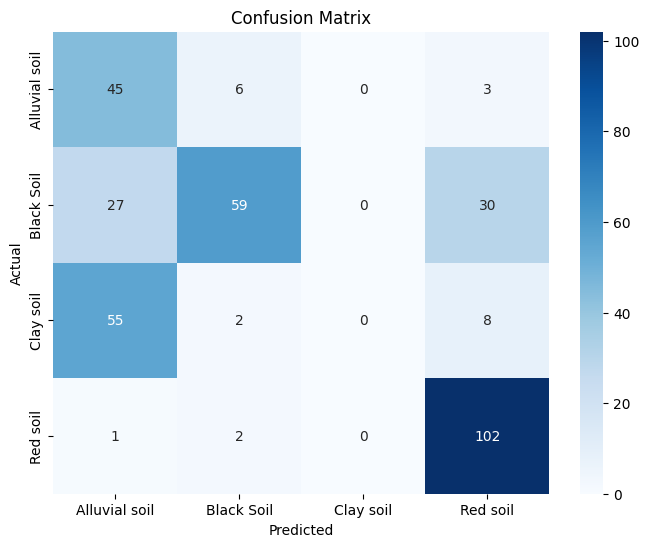

In [ ]:
# Install required packages (EfficientNet removed)
!pip install -q tqdm seaborn scikit-learn

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime (only if it doesn't already exist)
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # AlexNet expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # AlexNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model: AlexNet
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


 ShuffleNetV2

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 98.5MB/s]


Epoch [1/10] Train Loss: 0.8855 Train Acc: 0.8166 Val Loss: 0.3408 Val Acc: 0.8811


Epoch [2/10] Train Loss: 0.3375 Train Acc: 0.8996 Val Loss: 0.1956 Val Acc: 0.9303


Epoch [3/10] Train Loss: 0.2039 Train Acc: 0.9406 Val Loss: 0.1275 Val Acc: 0.9590


Epoch [4/10] Train Loss: 0.1510 Train Acc: 0.9611 Val Loss: 0.1210 Val Acc: 0.9672


Epoch [5/10] Train Loss: 0.0801 Train Acc: 0.9826 Val Loss: 0.1112 Val Acc: 0.9549


Epoch [6/10] Train Loss: 0.0512 Train Acc: 0.9836 Val Loss: 0.1472 Val Acc: 0.9467


Epoch [7/10] Train Loss: 0.0707 Train Acc: 0.9816 Val Loss: 0.1270 Val Acc: 0.9795


Epoch [8/10] Train Loss: 0.0476 Train Acc: 0.9877 Val Loss: 0.1421 Val Acc: 0.9590


Epoch [9/10] Train Loss: 0.0636 Train Acc: 0.9816 Val Loss: 0.1258 Val Acc: 0.9590


Epoch [10/10] Train Loss: 0.0848 Train Acc: 0.9775 Val Loss: 0.1145 Val Acc: 0.9672
Training complete.


Test Loss: 0.0647 Test Accuracy: 0.9912


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.96      0.98      0.97        54
   Black Soil       1.00      0.99      1.00       116
    Clay soil       0.98      0.98      0.98        65
     Red soil       1.00      1.00      1.00       105

     accuracy                           0.99       340
    macro avg       0.99      0.99      0.99       340
 weighted avg       0.99      0.99      0.99       340



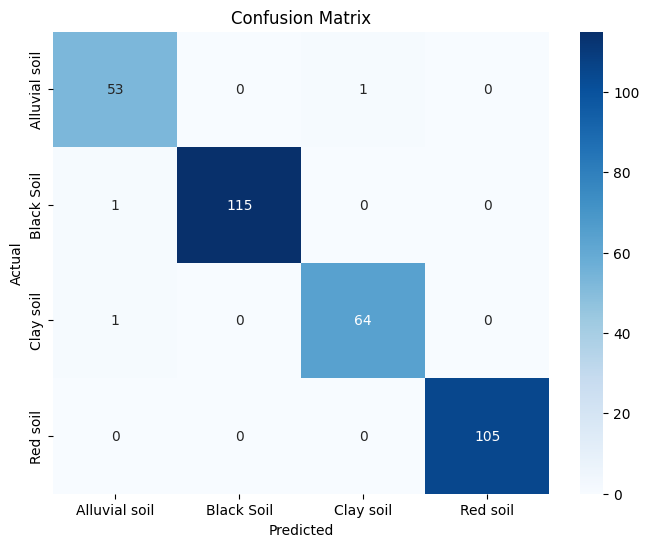

In [ ]:
# Install required packages
!pip install -q tqdm seaborn scikit-learn

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime (only if it doesn't already exist)
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # ShuffleNet expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # ShuffleNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model: ShuffleNetV2
model = models.shufflenet_v2_x1_0(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final layer
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Squeezb=net


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


Using device: cuda


100%|██████████| 4.78M/4.78M [00:00<00:00, 21.1MB/s]


Epoch [1/10] Train Loss: 0.7909 Train Acc: 0.7039 Val Loss: 0.6778 Val Acc: 0.7705


Epoch [2/10] Train Loss: 0.5136 Train Acc: 0.7951 Val Loss: 0.6218 Val Acc: 0.6926


Epoch [3/10] Train Loss: 0.3771 Train Acc: 0.8586 Val Loss: 0.3812 Val Acc: 0.8443


Epoch [4/10] Train Loss: 0.3228 Train Acc: 0.8760 Val Loss: 0.4395 Val Acc: 0.8607


Epoch [5/10] Train Loss: 0.2529 Train Acc: 0.9170 Val Loss: 0.3615 Val Acc: 0.8975


Epoch [6/10] Train Loss: 0.3804 Train Acc: 0.8986 Val Loss: 0.3327 Val Acc: 0.8852


Epoch [7/10] Train Loss: 0.2592 Train Acc: 0.9150 Val Loss: 0.3891 Val Acc: 0.9098


Epoch [8/10] Train Loss: 0.3099 Train Acc: 0.8965 Val Loss: 0.3340 Val Acc: 0.9057


Epoch [9/10] Train Loss: 0.2477 Train Acc: 0.9160 Val Loss: 0.2674 Val Acc: 0.9098


Epoch [10/10] Train Loss: 0.1389 Train Acc: 0.9559 Val Loss: 0.2669 Val Acc: 0.9221
Training complete.


Test Loss: 0.2277 Test Accuracy: 0.9324


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.78      0.80      0.79        54
   Black Soil       1.00      0.92      0.96       116
    Clay soil       0.85      0.95      0.90        65
     Red soil       1.00      1.00      1.00       105

     accuracy                           0.93       340
    macro avg       0.91      0.92      0.91       340
 weighted avg       0.94      0.93      0.93       340



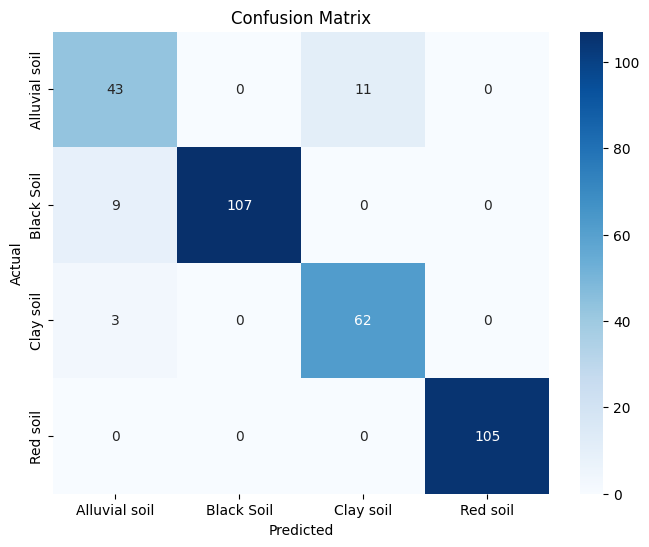

In [ ]:
# Install required packages
!pip install -q tqdm seaborn scikit-learn

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime (only if it doesn't already exist)
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # SqueezeNet expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # SqueezeNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model: SqueezeNet 1.0
model = models.squeezenet1_0(pretrained=True)
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
model.num_classes = num_classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


mobilenet


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Using device: cuda


100%|██████████| 13.6M/13.6M [00:00<00:00, 47.4MB/s]


Epoch [1/10] Train Loss: 0.5232 Train Acc: 0.8258 Val Loss: 0.5334 Val Acc: 0.8689


Epoch [2/10] Train Loss: 0.3122 Train Acc: 0.8893 Val Loss: 0.3056 Val Acc: 0.8975


Epoch [3/10] Train Loss: 0.2820 Train Acc: 0.8996 Val Loss: 0.1831 Val Acc: 0.9467


Epoch [4/10] Train Loss: 0.1832 Train Acc: 0.9426 Val Loss: 0.1250 Val Acc: 0.9549


Epoch [5/10] Train Loss: 0.1198 Train Acc: 0.9713 Val Loss: 0.2163 Val Acc: 0.9303


Epoch [6/10] Train Loss: 0.0834 Train Acc: 0.9744 Val Loss: 0.1544 Val Acc: 0.9344


Epoch [7/10] Train Loss: 0.1051 Train Acc: 0.9641 Val Loss: 0.1788 Val Acc: 0.9631


Epoch [8/10] Train Loss: 0.1903 Train Acc: 0.9467 Val Loss: 0.1406 Val Acc: 0.9590


Epoch [9/10] Train Loss: 0.1485 Train Acc: 0.9518 Val Loss: 0.6580 Val Acc: 0.8361


Epoch [10/10] Train Loss: 0.1246 Train Acc: 0.9600 Val Loss: 0.2419 Val Acc: 0.9262
Training complete.


Test Loss: 0.0721 Test Accuracy: 0.9824


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.93      0.98      0.95        54
   Black Soil       1.00      0.98      0.99       116
    Clay soil       0.98      0.95      0.97        65
     Red soil       0.99      1.00      1.00       105

     accuracy                           0.98       340
    macro avg       0.98      0.98      0.98       340
 weighted avg       0.98      0.98      0.98       340



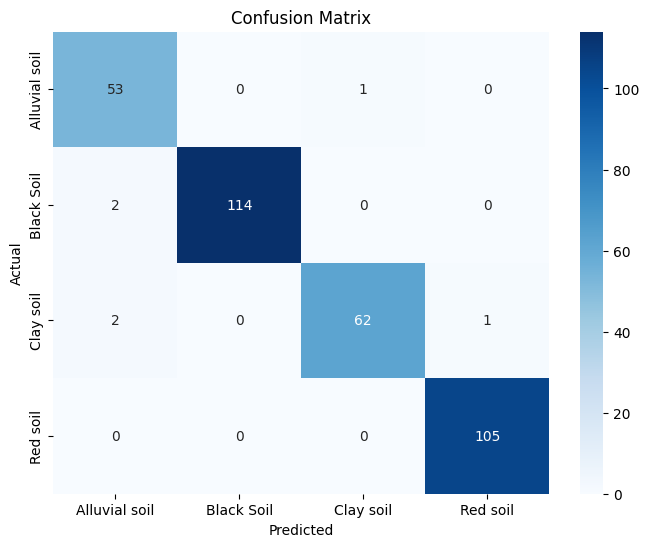

In [ ]:
# Install required packages (EfficientNet removed)
!pip install -q tqdm seaborn scikit-learn

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime (only if it doesn't already exist)
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # MobileNet expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # MobileNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model: MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
VGG-16

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 1.9007 Train Acc: 0.3648 Val Loss: 1.3232 Val Acc: 0.4508


Epoch [2/10] Train Loss: 1.3615 Train Acc: 0.4139 Val Loss: 1.0027 Val Acc: 0.4508


Epoch [3/10] Train Loss: 0.9812 Train Acc: 0.5666 Val Loss: 0.7537 Val Acc: 0.6926


Epoch [4/10] Train Loss: 0.8494 Train Acc: 0.6814 Val Loss: 0.7749 Val Acc: 0.7172


Epoch [5/10] Train Loss: 0.5989 Train Acc: 0.7408 Val Loss: 0.5483 Val Acc: 0.7336


Epoch [6/10] Train Loss: 0.5572 Train Acc: 0.7459 Val Loss: 0.6606 Val Acc: 0.7459


Epoch [7/10] Train Loss: 0.5144 Train Acc: 0.7592 Val Loss: 0.5397 Val Acc: 0.7295


Epoch [8/10] Train Loss: 0.4556 Train Acc: 0.7859 Val Loss: 0.4933 Val Acc: 0.7582


Epoch [9/10] Train Loss: 0.4525 Train Acc: 0.7920 Val Loss: 0.5361 Val Acc: 0.7623


Epoch [10/10] Train Loss: 0.4495 Train Acc: 0.8238 Val Loss: 0.5736 Val Acc: 0.7418
Training complete.


Test Loss: 0.5899 Test Accuracy: 0.7265


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.45      0.91      0.60        54
   Black Soil       1.00      0.74      0.85       116
    Clay soil       0.31      0.14      0.19        65
     Red soil       0.89      0.98      0.93       105

     accuracy                           0.73       340
    macro avg       0.66      0.69      0.64       340
 weighted avg       0.75      0.73      0.71       340



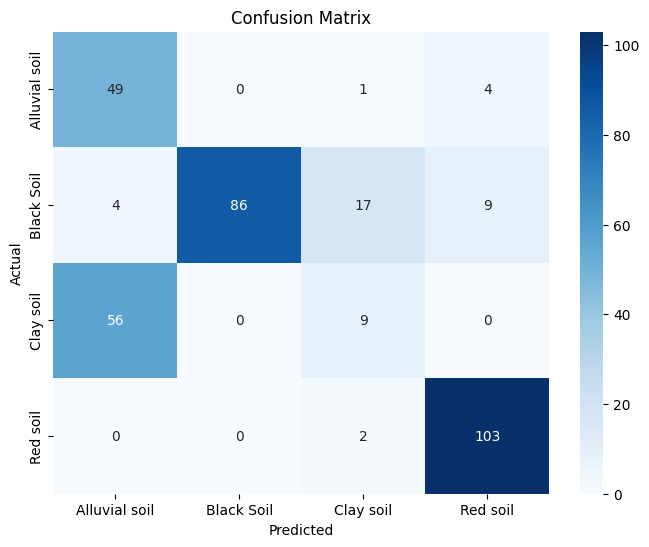

In [ ]:
# Install required packages (EfficientNet removed)
!pip install -q tqdm seaborn scikit-learn

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime (only if it doesn't already exist)
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # VGG expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # VGG input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model: VGG-16
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


ResNet-50

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Epoch [1/10] Train Loss: 0.6422 Train Acc: 0.7828 Val Loss: 0.8999 Val Acc: 0.7500


Epoch [2/10] Train Loss: 0.3834 Train Acc: 0.8535 Val Loss: 0.3004 Val Acc: 0.8770


Epoch [3/10] Train Loss: 0.4059 Train Acc: 0.8525 Val Loss: 0.3736 Val Acc: 0.8607


Epoch [4/10] Train Loss: 0.3918 Train Acc: 0.8709 Val Loss: 0.7859 Val Acc: 0.6680


Epoch [5/10] Train Loss: 0.3271 Train Acc: 0.8740 Val Loss: 0.2985 Val Acc: 0.9057


Epoch [6/10] Train Loss: 0.2488 Train Acc: 0.9057 Val Loss: 0.1980 Val Acc: 0.9262


Epoch [7/10] Train Loss: 0.2368 Train Acc: 0.9180 Val Loss: 0.2409 Val Acc: 0.8975


Epoch [8/10] Train Loss: 0.2570 Train Acc: 0.9160 Val Loss: 0.3042 Val Acc: 0.9098


Epoch [9/10] Train Loss: 0.2030 Train Acc: 0.9385 Val Loss: 0.2409 Val Acc: 0.9057


Epoch [10/10] Train Loss: 0.1838 Train Acc: 0.9488 Val Loss: 0.3616 Val Acc: 0.8770
Training complete.


Test Loss: 0.1590 Test Accuracy: 0.9441


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.91      0.76      0.83        54
   Black Soil       0.95      0.99      0.97       116
    Clay soil       0.91      0.92      0.92        65
     Red soil       0.97      1.00      0.99       105

     accuracy                           0.94       340
    macro avg       0.94      0.92      0.93       340
 weighted avg       0.94      0.94      0.94       340



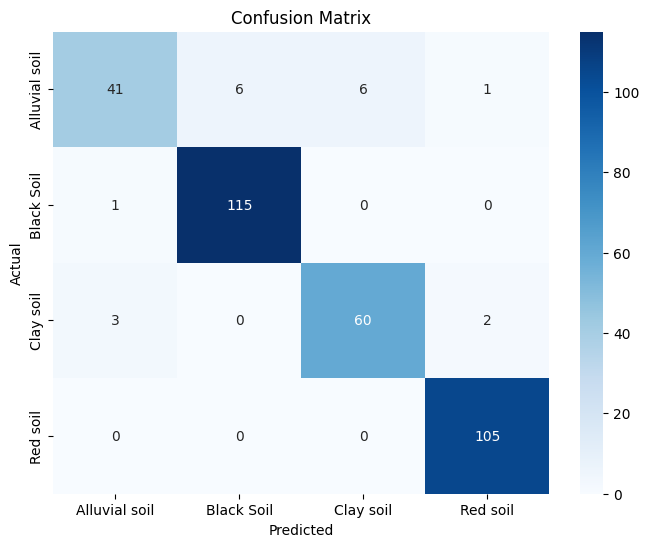

In [ ]:
# Install required packages
!pip install -q tqdm seaborn scikit-learn


import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime (only if it doesn't already exist)
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # ResNet expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model: ResNet-50
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


DenseNet-121,

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Using device: cuda


100%|██████████| 30.8M/30.8M [00:00<00:00, 160MB/s]


Epoch [1/10] Train Loss: 0.5080 Train Acc: 0.8197 Val Loss: 0.9247 Val Acc: 0.8402


Epoch [2/10] Train Loss: 0.3615 Train Acc: 0.8781 Val Loss: 0.7373 Val Acc: 0.8730


Epoch [3/10] Train Loss: 0.2532 Train Acc: 0.9139 Val Loss: 0.1841 Val Acc: 0.9180


Epoch [4/10] Train Loss: 0.2399 Train Acc: 0.9191 Val Loss: 0.2561 Val Acc: 0.9303


Epoch [5/10] Train Loss: 0.1623 Train Acc: 0.9436 Val Loss: 0.8901 Val Acc: 0.8852


Epoch [6/10] Train Loss: 0.1478 Train Acc: 0.9529 Val Loss: 0.1284 Val Acc: 0.9590


Epoch [7/10] Train Loss: 0.1390 Train Acc: 0.9529 Val Loss: 0.1405 Val Acc: 0.9549


Epoch [8/10] Train Loss: 0.1123 Train Acc: 0.9580 Val Loss: 0.2195 Val Acc: 0.9139


Epoch [9/10] Train Loss: 0.1457 Train Acc: 0.9570 Val Loss: 0.1736 Val Acc: 0.9385


Epoch [10/10] Train Loss: 0.1310 Train Acc: 0.9549 Val Loss: 0.2397 Val Acc: 0.9262
Training complete.


Test Loss: 0.1427 Test Accuracy: 0.9500


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.84      0.91      0.88        54
   Black Soil       0.98      0.96      0.97       116
    Clay soil       0.92      0.91      0.91        65
     Red soil       0.99      0.99      0.99       105

     accuracy                           0.95       340
    macro avg       0.93      0.94      0.94       340
 weighted avg       0.95      0.95      0.95       340



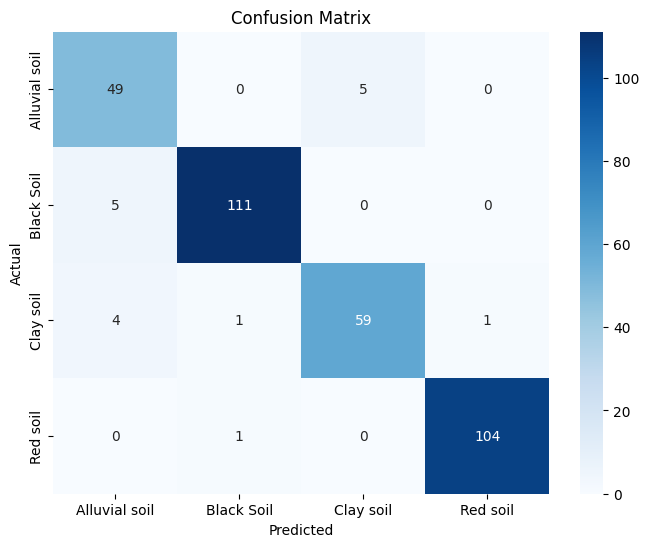

In [ ]:
# Install required packages
!pip install -q tqdm seaborn scikit-learn

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # DenseNet expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # DenseNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model: DenseNet-121
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# *Efficient net and ex ai*

Using device: cuda
Loaded pretrained weights for efficientnet-b0


Epoch [1/10] Train Acc: 0.8576  Val Acc: 0.6025


Epoch [2/10] Train Acc: 0.9344  Val Acc: 0.8443


Epoch [3/10] Train Acc: 0.9703  Val Acc: 0.9262


Epoch [4/10] Train Acc: 0.9713  Val Acc: 0.9467


Epoch [5/10] Train Acc: 0.9764  Val Acc: 0.9385


Epoch [6/10] Train Acc: 0.9734  Val Acc: 0.9508


Epoch [7/10] Train Acc: 0.9703  Val Acc: 0.9467


Epoch [8/10] Train Acc: 0.9795  Val Acc: 0.9426


Epoch [9/10] Train Acc: 0.9846  Val Acc: 0.9713


Epoch [10/10] Train Acc: 0.9857  Val Acc: 0.9508


Test Accuracy: 0.9853



Classification Report:

               precision    recall  f1-score   support

Alluvial soil       1.00      0.93      0.96        54
   Black Soil       1.00      0.99      1.00       116
    Clay soil       0.94      1.00      0.97        65
     Red soil       0.99      1.00      1.00       105

     accuracy                           0.99       340
    macro avg       0.98      0.98      0.98       340
 weighted avg       0.99      0.99      0.99       340


--- Sample 0 ---


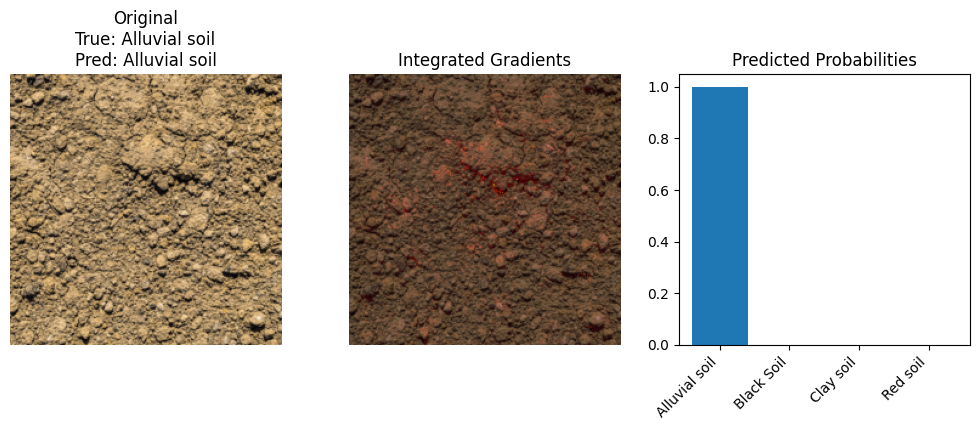

  0%|          | 0/1000 [00:00<?, ?it/s]

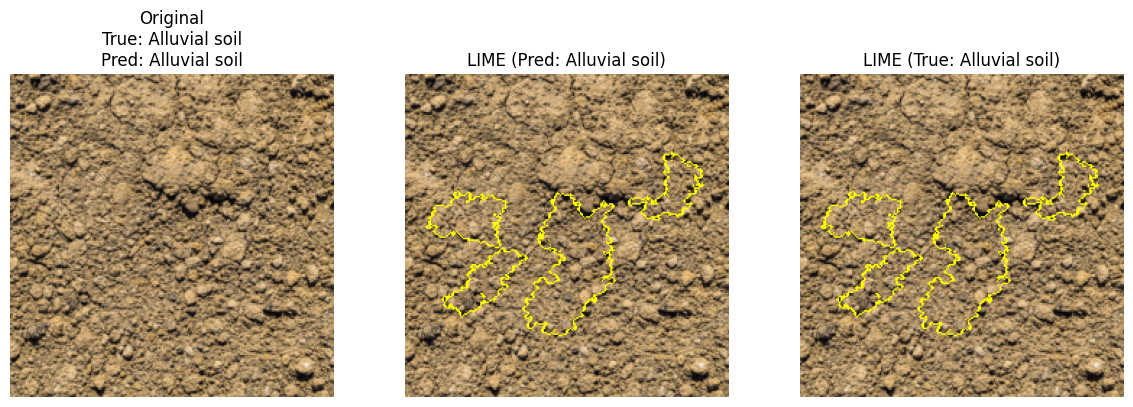

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: MemoryEfficientSwish
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: ZeroPad2d
  warnings.warn(f"unrecognized nn.Module: {module_type}")


SHAP DeepExplainer failed: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 2.831237610769084 - Tolerance: 0.01
Tip: Reduce background_size, or try shap.GradientExplainer / shap.KernelExplainer.

--- Sample 1 ---


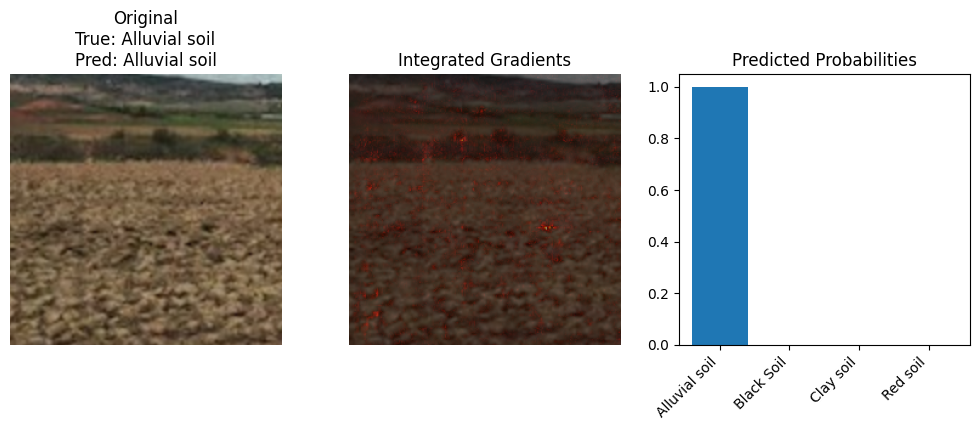

  0%|          | 0/1000 [00:00<?, ?it/s]

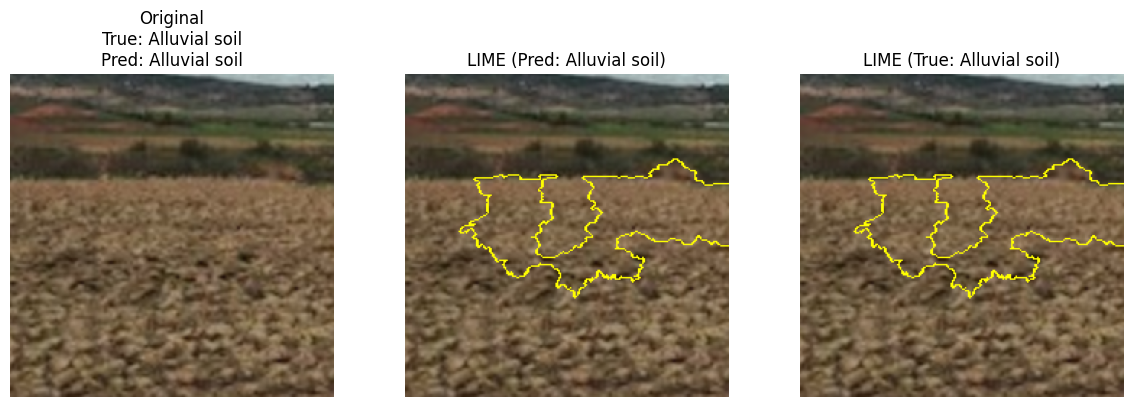

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: MemoryEfficientSwish
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: ZeroPad2d
  warnings.warn(f"unrecognized nn.Module: {module_type}")


SHAP DeepExplainer failed: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 5.4678068838576905 - Tolerance: 0.01
Tip: Reduce background_size, or try shap.GradientExplainer / shap.KernelExplainer.

--- Sample 2 ---


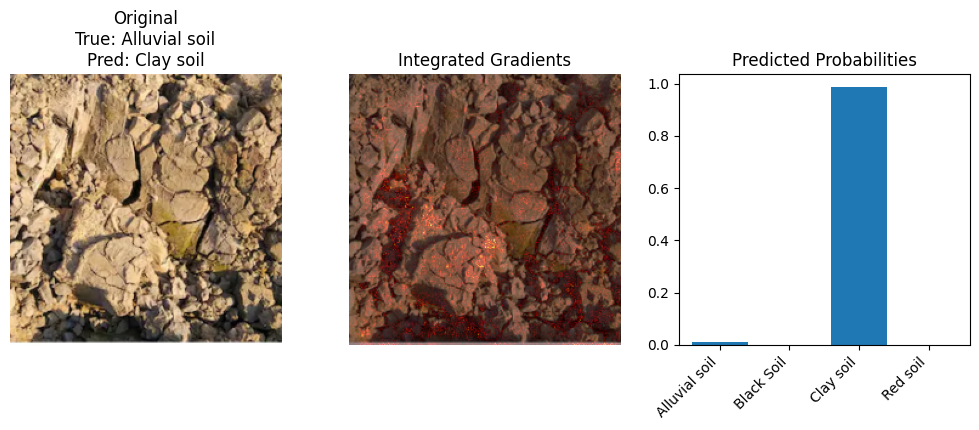

  0%|          | 0/1000 [00:00<?, ?it/s]

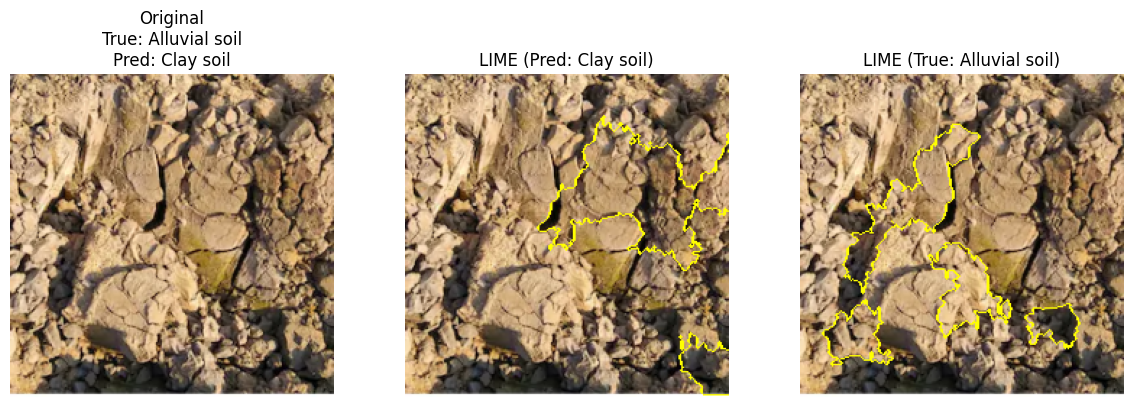

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: MemoryEfficientSwish
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: ZeroPad2d
  warnings.warn(f"unrecognized nn.Module: {module_type}")


SHAP DeepExplainer failed: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 9.781720645909296 - Tolerance: 0.01
Tip: Reduce background_size, or try shap.GradientExplainer / shap.KernelExplainer.


In [ ]:
# ============================
# Install required packages
# ============================
!pip install -q efficientnet_pytorch tqdm captum lime shap matplotlib scikit-image scikit-learn

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# XAI
from captum.attr import IntegratedGradients
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap


# ============================
# Device
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# Paths (update if needed)
# ============================
# Original Google Drive paths
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

# Local Colab paths
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# Copy data from Drive to local runtime (only if it doesn't already exist)
if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# ============================
# Hyperparameters
# ============================
batch_size = 32
num_epochs = 10      # increase for better accuracy
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

torch.manual_seed(random_seed)

# Normalization constants for ImageNet (EfficientNet expects these)
IM_MEAN = [0.485, 0.456, 0.406]
IM_STD  = [0.229, 0.224, 0.225]

# Helpers: de-normalize for visualization; normalize for model input
def denormalize(img_tensor):
    """img_tensor: CxHxW normalized. Returns CxHxW in [0,1]."""
    mean = torch.tensor(IM_MEAN, device=img_tensor.device).view(-1,1,1)
    std  = torch.tensor(IM_STD,  device=img_tensor.device).view(-1,1,1)
    out = img_tensor * std + mean
    return out.clamp(0, 1)

def normalize_bchw(batch):
    """batch: BxCxHxW in [0,1] -> normalized."""
    mean = torch.tensor(IM_MEAN, device=batch.device).view(1,-1,1,1)
    std  = torch.tensor(IM_STD,  device=batch.device).view(1,-1,1,1)
    return (batch - mean) / std


# ============================
# Transforms
# ============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IM_MEAN, std=IM_STD),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IM_MEAN, std=IM_STD),
])

# ============================
# Datasets & Loaders
# ============================
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
# use eval transforms for val split
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)
class_names = test_dataset.classes

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ============================
# Model
# ============================
model = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ============================
# Train / Eval
# ============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)      # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total   += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, dataloader, criterion, device, epoch=None, desc="Validation"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} {desc}" if epoch is not None else desc, leave=False)
    for images, labels in loop:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total   += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

best_val_acc = 0.0
for epoch in range(num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device, epoch, desc="Validation")
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Acc: {tr_acc:.4f}  Val Acc: {va_acc:.4f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "best_model.pth")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth", map_location=device))
test_loss, test_acc = evaluate(model, test_loader, criterion, device, desc="Testing")
print(f"Test Accuracy: {test_acc:.4f}")

# Optional: confusion matrix + report
@torch.no_grad()
def get_all_predictions(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy().tolist())
    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_all_predictions(model, test_loader, device)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# ============================
# XAI: Integrated Gradients
# ============================
def show_integrated_gradients(model, dataset, device, idx=0, class_names=None):
    if idx >= len(dataset):
        print(f"Index {idx} out of range for dataset of size {len(dataset)}.")
        return
    model.eval()
    image, label = dataset[idx]               # normalized tensor
    image_batch = image.unsqueeze(0).to(device)

    # prediction for info
    with torch.no_grad():
        logits = model(image_batch)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
        pred_label = int(logits.argmax(dim=1).cpu().item())

    ig = IntegratedGradients(model)
    attributions = ig.attribute(image_batch, target=label, n_steps=50)
    attr = attributions.squeeze().detach().cpu().numpy()
    attr = np.abs(attr).mean(axis=0)          # HxW

    # visuals
    img_vis = denormalize(image).permute(1,2,0).cpu().numpy()
    attr_norm = (attr - attr.min())/(attr.max()-attr.min()+1e-8)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(img_vis)
    plt.title(f"Original\nTrue: {class_names[label]}\nPred: {class_names[pred_label]}")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img_vis)
    plt.imshow(attr_norm, cmap='hot', alpha=0.5)
    plt.title("Integrated Gradients")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.bar(range(len(class_names)), probs)
    plt.title("Predicted Probabilities")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ============================
# XAI: LIME (fixed to avoid KeyError)
# ============================
def explain_with_lime(model, dataset, device, idx=0, class_names=None, explain_true_and_pred=True):
    if idx >= len(dataset):
        print(f"Index {idx} out of range for dataset of size {len(dataset)}.")
        return
    model.eval()
    # grab normalized tensor
    image, true_label = dataset[idx]
    # de-normalize for LIME's perturbations/visuals
    image_denorm = denormalize(image).cpu()           # CxHxW in [0,1]
    img_np = image_denorm.permute(1,2,0).numpy()      # HxWxC in [0,1]

    # LIME expects unnormalized pixel arrays; we re-normalize inside predict_fn
    def predict_fn(images):
        # images: NxHxWxC in [0,1]
        images = torch.tensor(images.transpose((0,3,1,2))).float().to(device)  # NxCxHxW
        images = normalize_bchw(images)
        with torch.no_grad():
            outputs = model(images)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
        return probs

    explainer = lime_image.LimeImageExplainer()
    # explain a handful of top labels to optionally allow true label visualization
    explanation = explainer.explain_instance(
        img_np,
        classifier_fn=predict_fn,
        top_labels=min(len(class_names), 3),
        hide_color=0,
        num_samples=1000
    )

    # predicted label (first of top_labels)
    pred_label = int(explanation.top_labels[0])

    # Helper to draw one map
    def draw_panel(target_label, title):
        temp, mask = explanation.get_image_and_mask(
            target_label,
            positive_only=True,
            hide_rest=False,
            num_features=5,
            min_weight=0.0
        )
        plt.imshow(mark_boundaries(temp, mask))
        plt.title(title)
        plt.axis("off")

    # Plot original + LIME for predicted; and (if available) for true
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title(f"Original\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis("off")

    plt.subplot(1,3,2)
    draw_panel(pred_label, f"LIME (Pred: {class_names[pred_label]})")

    if explain_true_and_pred and true_label in explanation.local_exp:
        plt.subplot(1,3,3)
        draw_panel(true_label, f"LIME (True: {class_names[true_label]})")
    else:
        plt.subplot(1,3,3)
        plt.text(0.5, 0.5, "True label not in LIME\ntop_labels", ha='center', va='center')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ============================
# XAI: SHAP (DeepExplainer)
# ============================
def explain_with_shap(model, dataset, device, idx=0, class_names=None, background_size=20):
    if idx >= len(dataset):
        print(f"Index {idx} out of range for dataset of size {len(dataset)}.")
        return
    model.eval()
    image, true_label = dataset[idx]                     # normalized CxHxW
    img_batch = image.unsqueeze(0).to(device)            # 1xCxHxW

    # build small background set (normalized) for DeepExplainer
    bg_count = min(background_size, len(dataset))
    bg_tensors = []
    for i in range(bg_count):
        bg_tensors.append(dataset[i][0])                 # normalized tensor
    background = torch.stack(bg_tensors).to(device)      # BxCxHxW

    # get prediction for info
    with torch.no_grad():
        logits = model(img_batch)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
        pred_label = int(logits.argmax(dim=1).cpu().item())

    # Run SHAP
    try:
        explainer = shap.DeepExplainer(model, background)
        shap_values = explainer.shap_values(img_batch)   # list length = num_classes
        # SHAP sometimes returns numpy arrays already; normalize handling:
        def to_hw(shap_arr):
            if isinstance(shap_arr, torch.Tensor):
                arr = shap_arr.detach().cpu().numpy()
            else:
                arr = np.array(shap_arr)
            # shape could be (1,C,H,W) per class -> squeeze then sum |.| over channels
            arr = np.squeeze(arr)  # CxHxW
            if arr.ndim == 3:
                arr = np.abs(arr).mean(axis=0)  # HxW
            return arr

        # build heatmaps for predicted and (if desired) true
        shap_pred = to_hw(shap_values[pred_label])
        shap_true = to_hw(shap_values[true_label])

        img_vis = denormalize(image).permute(1,2,0).cpu().numpy()
        pred_map = (shap_pred - shap_pred.min())/(shap_pred.max()-shap_pred.min()+1e-8)
        true_map = (shap_true - shap_true.min())/(shap_true.max()-shap_true.min()+1e-8)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img_vis)
        plt.title(f"Original\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(img_vis)
        plt.imshow(pred_map, cmap='hot', alpha=0.5)
        plt.title(f"SHAP (Pred: {class_names[pred_label]})")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(img_vis)
        plt.imshow(true_map, cmap='hot', alpha=0.5)
        plt.title(f"SHAP (True: {class_names[true_label]})")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP DeepExplainer failed: {e}")
        print("Tip: Reduce background_size, or try shap.GradientExplainer / shap.KernelExplainer.")

# ============================
# Run explanations on a few test samples
# ============================
num_to_show = min(3, len(test_dataset))
for idx in range(num_to_show):
    print(f"\n--- Sample {idx} ---")
    show_integrated_gradients(model, test_dataset, device, idx=idx, class_names=class_names)
    explain_with_lime(model, test_dataset, device, idx=idx, class_names=class_names)
    explain_with_shap(model, test_dataset, device, idx=idx, class_names=class_names, background_size=12)


# DP CODE EX_AI

In [ ]:
# ============================
# Install required packages
# ============================
!pip install -q torchvision tqdm opacus captum lime matplotlib scikit-learn

# ============================
# Imports
# ============================
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# XAI
from captum.attr import IntegratedGradients, Saliency, LayerGradCam, visualization as viz
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager

# ============================
# Device
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# Paths (update if needed)
# ============================
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# ============================
# Hyperparameters
# ============================
BATCH_SIZE = 64
MAX_PHYSICAL_BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
MAX_GRAD_NORM = 1.2
DELTA = 1e-5
EPSILON = 50.0
validation_split = 0.2
random_seed = 42

torch.manual_seed(random_seed)

# ============================
# Transforms
# ============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ============================
# Datasets & Loaders
# ============================
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)
class_names = full_train_dataset.classes

train_loader_base = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ============================
# Model
# ============================
num_classes = len(class_names)
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Fix ReLU inplace
for module in model.modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False

# Opacus fixes
model = ModuleValidator.fix(model)
ModuleValidator.validate(model, strict=False)
model = model.to(device)

optimizer = optim.RMSprop(model.parameters(), lr=LR)

# ============================
# Differential Privacy
# ============================
privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader_base,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM
)
print(f"Using sigma={optimizer.noise_multiplier:.4f} and C={MAX_GRAD_NORM}")

# ============================
# Training
# ============================
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, optimizer, device):
    model.train()
    with BatchMemoryManager(
        data_loader=train_loader,
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE,
        optimizer=optimizer
    ) as memory_safe_data_loader:
        for images, labels in memory_safe_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    train(model, train_loader, optimizer, device)

# Save DP-trained model
torch.save(model.state_dict(), "model_dp.pth")

# ============================
# Load DP model (fix _module)
# ============================
state_dict = torch.load("model_dp.pth", map_location=device)
new_state_dict = {k.replace("_module.", ""):v for k,v in state_dict.items()}

model_eval = models.resnet18(pretrained=False)
in_features = model_eval.fc.in_features
model_eval.fc = nn.Linear(in_features, num_classes)
model_eval.load_state_dict(new_state_dict)
model_eval = model_eval.to(device)
model_eval.eval()

# ============================
# Evaluation
# ============================
def evaluate(model, loader):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {acc*100:.2f}%")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)
    return acc

evaluate(model_eval, test_loader)

# ============================
# Helper: denormalize
# ============================
def denormalize(img_tensor):
    mean = torch.tensor([0.485,0.456,0.406], device=img_tensor.device).view(-1,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=img_tensor.device).view(-1,1,1)
    return (img_tensor*std + mean).clamp(0,1)

# ============================
# XAI: Integrated Gradients
# ============================
def show_integrated_gradients(model, dataset, idx=0):
    model.eval()
    img, label = dataset[idx]
    img_batch = img.unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(img_batch)
        pred_label = int(logits.argmax(dim=1).cpu().item())
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    ig = IntegratedGradients(model)
    attr = ig.attribute(img_batch, target=label, n_steps=50)
    attr = np.abs(attr.squeeze().detach().cpu().numpy()).mean(axis=0)

    img_vis = denormalize(img).permute(1,2,0).cpu().numpy()
    attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(img_vis)
    plt.title(f"Original\nTrue: {class_names[label]}\nPred: {class_names[pred_label]}")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_vis)
    plt.imshow(attr_norm, cmap='hot', alpha=0.5)
    plt.title("Integrated Gradients")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.bar(range(len(class_names)), probs)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.title("Pred Probabilities")
    plt.tight_layout()
    plt.show()

# ============================
# XAI: Saliency
# ============================
def show_saliency(model, dataset, idx=0):
    model.eval()
    img, label = dataset[idx]
    img_batch = img.unsqueeze(0).to(device)
    sal = Saliency(model)
    attr = sal.attribute(img_batch, target=label)
    attr = np.abs(attr.squeeze().detach().cpu().numpy()).mean(axis=0)

    img_vis = denormalize(img).permute(1,2,0).cpu().numpy()
    attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
    plt.imshow(img_vis)
    plt.imshow(attr_norm, cmap='hot', alpha=0.5)
    plt.title(f"Saliency Map")
    plt.axis('off')
    plt.show()

# ============================
# XAI: Grad-CAM
# ============================
def show_gradcam(model, dataset, idx=0):
    model.eval()
    img, label = dataset[idx]
    img_batch = img.unsqueeze(0).to(device)
    target_layer = model.layer4[1].conv2
    lgc = LayerGradCam(model, target_layer)
    attr = lgc.attribute(img_batch, target=label)
    attr = torch.nn.functional.interpolate(attr, size=(224,224), mode='bilinear', align_corners=False)
    attr = attr.squeeze().detach().cpu().numpy()
    attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
    img_vis = denormalize(img).permute(1,2,0).cpu().numpy()
    plt.imshow(img_vis)
    plt.imshow(attr_norm, cmap='hot', alpha=0.5)
    plt.title(f"Grad-CAM")
    plt.axis('off')
    plt.show()

# ============================
# XAI: LIME
# ============================
def show_lime(model, dataset, idx=0):
    model.eval()
    img, label = dataset[idx]
    img_denorm = denormalize(img).cpu().permute(1,2,0).numpy()
    def predict_fn(images):
        imgs = torch.tensor(images.transpose((0,3,1,2))).float().to(device)
        mean = torch.tensor([0.485,0.456,0.406], device=imgs.device).view(1,3,1,1)
        std  = torch.tensor([0.229,0.224,0.225], device=imgs.device).view(1,3,1,1)
        imgs = (imgs - mean)/std
        with torch.no_grad():
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
        return probs
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_denorm, classifier_fn=predict_fn, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=False, num_features=5)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME")
    plt.axis('off')
    plt.show()

# ============================
# Run XAI for first 5 images
# ============================
for idx in range(min(5, len(test_dataset))):
    print(f"\n--- Sample {idx} ---")
    show_integrated_gradients(model_eval, test_dataset, idx)
    show_saliency(model_eval, test_dataset, idx)
    show_gradcam(model_eval, test_dataset, idx)
    show_lime(model_eval, test_dataset, idx)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

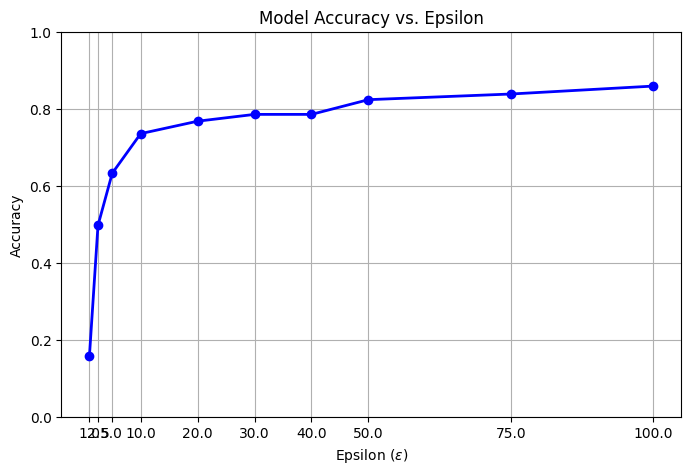

In [ ]:
import matplotlib.pyplot as plt

# Data
epsilon = [1.0, 2.5, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 75.0, 100.0]
accuracy = [0.1588, 0.4971, 0.6324, 0.7353, 0.7676, 0.7853, 0.7853, 0.8235, 0.8382, 0.8588]

# Plot
plt.figure(figsize=(8,5))
plt.plot(epsilon, accuracy, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('Model Accuracy vs. Epsilon')
plt.xlabel('Epsilon ($\epsilon$)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(epsilon)
plt.ylim(0, 1)
plt.show()


# DP with EX-AI

In [ ]:
=========================
# Imports
# ============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# XAI
from captum.attr import IntegratedGradients, Saliency, LayerGradCam
from lime import lime_image
from skimage.segmentation import mark_boundaries

# DP
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

# ============================
# Device
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# Paths (change as needed)
# ============================
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir  = "/content/drive/MyDrive/datasets/test"

train_dir = "/content/Dataset/Train"
test_dir  = "/content/Dataset/test"

if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# ============================
# Hyperparameters
# ============================
BATCH_SIZE = 64
MAX_PHYSICAL_BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
DELTA = 1e-5
MAX_GRAD_NORM = 1.2
EPSILON = 50.0
VALID_SPLIT = 0.2
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

# ============================
# Data transforms
# ============================
IM_MEAN = [0.485, 0.456, 0.406]
IM_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IM_MEAN, std=IM_STD),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IM_MEAN, std=IM_STD),
])

# ============================
# Datasets & Loaders
# ============================
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(VALID_SPLIT * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)
class_names = test_dataset.classes
num_classes = len(class_names)

train_loader_base = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader       = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader      = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ============================
# Accuracy function
# ============================
def accuracy(preds, labels):
    return (preds == labels).mean()

# ============================
# Model (ResNet18)
# ============================
def create_model(num_classes):
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Fix in-place ReLU for DP compatibility
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False

    model = ModuleValidator.fix(model)
    ModuleValidator.validate(model, strict=False)
    return model

# ============================
# Training function
# ============================
def train(model, train_loader, optimizer, epoch, device, privacy_engine=None):
    model.train()
    losses, top1_acc = [], []

    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = nn.CrossEntropyLoss()(output, target)
        preds = output.argmax(dim=1)
        acc = accuracy(preds.cpu().numpy(), target.cpu().numpy())
        losses.append(loss.item())
        top1_acc.append(acc)
        loss.backward()
        optimizer.step()

        if privacy_engine is not None and (i+1) % 50 == 0:
            epsilon_curr = privacy_engine.get_epsilon(DELTA)
            print(f"\tEpoch {epoch} Batch {i+1}: Loss {np.mean(losses):.4f}, Acc {np.mean(top1_acc)*100:.2f}% (ε={epsilon_curr:.2f}, δ={DELTA})")

# ============================
# Test function
# ============================
@torch.no_grad()
def test(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    for images, target in test_loader:
        images, target = images.to(device), target.to(device)
        output = model(images)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    acc = accuracy(np.array(all_preds), np.array(all_labels))

    print(f"Test Accuracy: {acc*100:.2f}%")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return all_preds, all_labels

# ============================
# Train with DP
# ============================
model_dp = create_model(num_classes).to(device)
optimizer = optim.RMSprop(model_dp.parameters(), lr=LR)
privacy_engine = PrivacyEngine()
model_dp, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model_dp,
    optimizer=optimizer,
    data_loader=train_loader_base,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)
print(f"DP training sigma={optimizer.noise_multiplier:.4f}, C={MAX_GRAD_NORM}")

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    train(model_dp, train_loader, optimizer, epoch+1, device, privacy_engine)

torch.save(model_dp.state_dict(), "model_dp.pth")

# ============================
# Reload fresh model for XAI
# ============================
model = create_model(num_classes).to(device)
state_dict = torch.load("model_dp.pth", map_location=device)
new_state_dict = {k.replace('_module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

# Test evaluation
y_pred, y_true = test(model, test_loader, device, class_names)

# ============================
# XAI helpers
# ============================
def denormalize(img_tensor):
    mean = torch.tensor(IM_MEAN, device=img_tensor.device).view(-1,1,1)
    std  = torch.tensor(IM_STD, device=img_tensor.device).view(-1,1,1)
    return (img_tensor * std + mean).clamp(0,1)

def show_integrated_gradients(model, dataset, idx=0):
    model.eval()
    img, label = dataset[idx]
    img_batch = img.unsqueeze(0).to(device)
    pred = model(img_batch).argmax(dim=1).item()
    ig = IntegratedGradients(model)
    attr = ig.attribute(img_batch, target=label, n_steps=50)
    attr = attr.squeeze().cpu().numpy()
    attr = np.abs(attr).mean(axis=0)

    img_vis = denormalize(img).permute(1,2,0).cpu().numpy()
    attr_norm = (attr - attr.min())/(attr.max()-attr.min()+1e-8)

    plt.figure(figsize=(5,5))
    plt.imshow(img_vis)
    plt.imshow(attr_norm, cmap='hot', alpha=0.5)
    plt.title(f"Integrated Gradients\nLabel={class_names[label]}, Pred={class_names[pred]}")
    plt.axis("off")
    plt.show()

def show_saliency(model, dataset, idx=0):
    model.eval()
    img, label = dataset[idx]
    img_batch = img.unsqueeze(0).to(device)
    img_batch.requires_grad_()
    output = model(img_batch)
    pred = output.argmax(dim=1).item()
    output[0,pred].backward()
    saliency = img_batch.grad.abs().squeeze().cpu().numpy().mean(axis=0)

    img_vis = denormalize(img).permute(1,2,0).cpu().numpy()
    sal_norm = (saliency - saliency.min())/(saliency.max()-saliency.min()+1e-8)

    plt.figure(figsize=(5,5))
    plt.imshow(img_vis)
    plt.imshow(sal_norm, cmap='hot', alpha=0.5)
    plt.title(f"Saliency Map\nLabel={class_names[label]}, Pred={class_names[pred]}")
    plt.axis("off")
    plt.show()

def show_gradcam(model, dataset, idx=0, layer=None):
    if layer is None:
        layer = model.layer4[-1]
    model.eval()
    img, label = dataset[idx]
    img_batch = img.unsqueeze(0).to(device)
    cam = LayerGradCam(model, layer)
    attr = cam.attribute(img_batch, target=label).squeeze().cpu().detach().numpy()
    attr = (attr - attr.min())/(attr.max()-attr.min()+1e-8)

    img_vis = denormalize(img).permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(img_vis)
    plt.imshow(attr, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()

def explain_with_lime(model, dataset, idx=0):
    model.eval()
    img, label = dataset[idx]
    img_denorm = denormalize(img).cpu().permute(1,2,0).numpy()

    def predict_fn(images):
        images = torch.tensor(images.transpose((0,3,1,2))).float().to(device)
        images = (images - torch.tensor(IM_MEAN, device=device).view(1,3,1,1))/torch.tensor(IM_STD, device=device).view(1,3,1,1)
        with torch.no_grad():
            outputs = model(images)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
        return probs

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_denorm, classifier_fn=predict_fn, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME Explanation")
    plt.axis("off")
    plt.show()

# ============================
# Run XAI on at least one image per class
# ============================
shown_classes = set()
for idx, (img, label) in enumerate(test_dataset):
    pred = model(img.unsqueeze(0).to(device)).argmax(dim=1).item()

    if label not in shown_classes or pred != label:  # show at least one correct or misclassified
        print(f"\n=== Test Image {idx} (Class={class_names[label]}, Pred={class_names[pred]}) ===")
        show_integrated_gradients(model, test_dataset, idx)
        show_saliency(model, test_dataset, idx)
        show_gradcam(model, test_dataset, idx)
        explain_with_lime(model, test_dataset, idx)
        shown_classes.add(label)

    if len(shown_classes) == num_classes:
        break


SyntaxError: invalid syntax (ipython-input-3609597097.py, line 1)

FROM RAMJAN INSTRUCTIONS

In [ ]:
# ============================
# Install required packages
# ============================
!pip install -q efficientnet_pytorch tqdm scikit-learn matplotlib

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Device Check
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# Paths
# ============================
drive_train_dir = "/content/drive/MyDrive/datasets/Train"
drive_test_dir = "/content/drive/MyDrive/datasets/test"

train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

if not os.path.exists(train_dir):
    shutil.copytree(drive_train_dir, train_dir)
if not os.path.exists(test_dir):
    shutil.copytree(drive_test_dir, test_dir)

# ============================
# Parameters
# ============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42
num_classes = 4

# ============================
# Data transforms
# ============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ============================
# Dataset & Dataloader
# ============================
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ============================
# Model
# ============================
model = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ============================
# Training & Validation
# ============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    return running_loss / total, correct / total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=running_loss/total, acc=correct/total)

    return running_loss / total, correct / total

# ============================
# Training Loop
# ============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# ============================
# Test Evaluation (All Metrics + Confusion Matrix)
# ============================
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1] if num_classes == 2 else np.max(probs.cpu().numpy(), axis=1))

# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr') if num_classes > 2 else roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)

print("\nClassification Report:\n", classification_report(all_labels, all_preds))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, "
      f"F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc:.4f}")

# ============================
# Confusion Matrix Plot
# ============================
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Using device: cuda
Loaded pretrained weights for efficientnet-b0


Epoch [1/10] Train Loss: 0.4445 Train Acc: 0.8576 Val Loss: 2.3179 Val Acc: 0.6107


Epoch [2/10] Train Loss: 0.2169 Train Acc: 0.9344 Val Loss: 0.5856 Val Acc: 0.8443


Epoch [3/10] Train Loss: 0.0989 Train Acc: 0.9703 Val Loss: 0.2006 Val Acc: 0.9262


Epoch [4/10] Train Loss: 0.0953 Train Acc: 0.9713 Val Loss: 0.2151 Val Acc: 0.9467


Epoch [5/10] Train Loss: 0.0846 Train Acc: 0.9764 Val Loss: 0.3522 Val Acc: 0.9385


Epoch [6/10] Train Loss: 0.0847 Train Acc: 0.9734 Val Loss: 0.1636 Val Acc: 0.9508


Epoch [7/10] Train Loss: 0.1124 Train Acc: 0.9703 Val Loss: 0.2128 Val Acc: 0.9467


Epoch [8/10] Train Loss: 0.0739 Train Acc: 0.9805 Val Loss: 0.1595 Val Acc: 0.9426


Epoch [9/10] Train Loss: 0.0497 Train Acc: 0.9846 Val Loss: 0.1169 Val Acc: 0.9713


Epoch [10/10] Train Loss: 0.0437 Train Acc: 0.9857 Val Loss: 0.1582 Val Acc: 0.9508
Training complete.


AxisError: axis 1 is out of bounds for array of dimension 1

Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
Epoch 1/10 - Loss: 0.8728, Train Acc: 0.6588, Val Acc: 0.8934
Epoch 2/10 - Loss: 0.4535, Train Acc: 0.8852, Val Acc: 0.9139
Epoch 3/10 - Loss: 0.3417, Train Acc: 0.8924, Val Acc: 0.9221
Epoch 4/10 - Loss: 0.2977, Train Acc: 0.9057, Val Acc: 0.9262
Epoch 5/10 - Loss: 0.2521, Train Acc: 0.9314, Val Acc: 0.9221
Epoch 6/10 - Loss: 0.2335, Train Acc: 0.9385, Val Acc: 0.9385
Epoch 7/10 - Loss: 0.2184, Train Acc: 0.9365, Val Acc: 0.9467
Epoch 8/10 - Loss: 0.1961, Train Acc: 0.9488, Val Acc: 0.9467
Epoch 9/10 - Loss: 0.1948, Train Acc: 0.9447, Val Acc: 0.9508
Epoch 10/10 - Loss: 0.1654, Train Acc: 0.9570, Val Acc: 0.9590
Training complete.

Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.89      0.91      0.90        54
   Black Soil       0.98      0.97      0.97       116
    Clay soil       0.95      0.95      0.95        65
     Red soil       0.99      1.00      1.00    

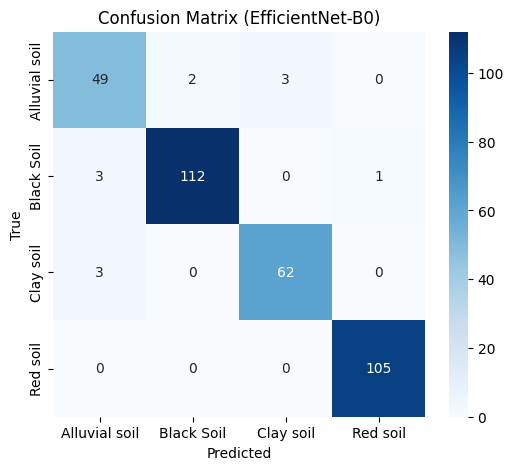

all_probs has unexpected dimensions (1360,). Skipping ROC plot for class Alluvial soil.
all_probs has unexpected dimensions (1360,). Skipping ROC plot for class Black Soil.
all_probs has unexpected dimensions (1360,). Skipping ROC plot for class Clay soil.
all_probs has unexpected dimensions (1360,). Skipping ROC plot for class Red soil.


/tmp/ipython-input-13051860.py:225: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


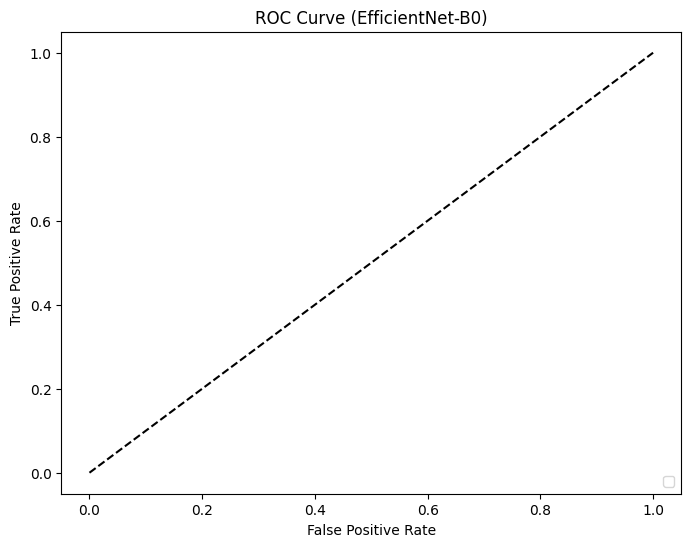

In [ ]:
# =============================
# Soil Classification System
# EfficientNet with Confusion Matrix & ROC
# =============================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# =============================
# Parameters
# =============================
data_dir = "/content/Dataset"
batch_size = 32
num_epochs = 10
learning_rate = 0.001
validation_split = 0.2  # Added validation split parameter
random_seed = 42        # Added random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================
# Data Preparation
# =============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the full training dataset
full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, "Train"), transform=transform)

# Split the training dataset into training and validation sets
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size
torch.manual_seed(random_seed) # for reproducible split
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(full_train_dataset.classes) # Get class names from the original full dataset
print("Classes:", full_train_dataset.classes)

# =============================
# Model: EfficientNet-B0
# =============================
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False   # freeze backbone

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

# =============================
# Training Loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Validation
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_acc = val_corrects.double() / len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet.pth")

print("Training complete.")

# =============================
# Test Evaluation (All Metrics + Confusion Matrix)
# =============================
model.load_state_dict(torch.load("best_efficientnet.pth"))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.concatenate(all_probs, axis=0).astype(float) # Concatenate the list of arrays and ensure float type


# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)

# Calculate overall AUC (OVR) - Removed due to persistent ValueError
# if num_classes > 2:
#     try:
#         auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr')
#     except ValueError:
#         print("Could not calculate overall OVR AUC. Skipping.")
#         auc_score = np.nan # Assign NaN if calculation fails
# else:
#     auc_score = roc_auc_score(all_labels, all_probs)

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes)) # Use full_train_dataset for target names
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, "
      f"F1: {f1:.4f}, MAE: {mae:.4f}")
      # Removed AUC from print statement


# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes, # Use full_train_dataset for tick labels
            yticklabels=full_train_dataset.classes) # Use full_train_dataset for tick labels
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (EfficientNet-B0)")
plt.savefig("confusion_matrix_efficientnet.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
plotted_roc = False # Flag to check if any ROC curves were plotted
if num_classes > 2:
    y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    for i in range(num_classes):
        try:
            # Ensure all_probs is 2D before accessing column
            if all_probs.ndim != 2:
                 print(f"all_probs has unexpected dimensions {all_probs.shape}. Skipping ROC plot for class {full_train_dataset.classes[i]}.")
                 continue # Skip plotting for this class if all_probs is not 2D

            # Check if there are enough samples and variation for ROC
            if len(np.unique(y_bin[:, i])) < 2 or len(np.unique(all_probs[:, i])) < 2:
                 print(f"Could not plot ROC for class {full_train_dataset.classes[i]} (index {i}). Skipping due to insufficient data or constant predictions.")
                 continue

            fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})") # Use full_train_dataset for labels
            plotted_roc = True # Set flag to True if plotting was successful
        except ValueError as e:
             print(f"Could not plot ROC for class {full_train_dataset.classes[i]} (index {i}). Skipping due to ValueError: {e}")
else:
    # Binary case
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1]) # Assuming binary case, use probability of positive class
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.2f})")
    plotted_roc = True # Set flag to True for binary case

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (EfficientNet-B0)")
if plotted_roc: # Only plot legend if at least one ROC curve was plotted
    plt.legend(loc="lower right")
plt.savefig("roc_curve_efficientnet.png", dpi=300)
plt.show()

new trainded model EfficentNEt

Using device: cuda
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 167MB/s]


Loaded pretrained weights for efficientnet-b0


Epoch [1/10] Train Loss: 0.4445 Train Acc: 0.8576 Val Loss: 2.3190 Val Acc: 0.6107


Epoch [2/10] Train Loss: 0.2169 Train Acc: 0.9344 Val Loss: 0.5857 Val Acc: 0.8443


Epoch [3/10] Train Loss: 0.0989 Train Acc: 0.9703 Val Loss: 0.2006 Val Acc: 0.9262


Epoch [4/10] Train Loss: 0.0953 Train Acc: 0.9713 Val Loss: 0.2151 Val Acc: 0.9467


Epoch [5/10] Train Loss: 0.0846 Train Acc: 0.9764 Val Loss: 0.3522 Val Acc: 0.9385


Epoch [6/10] Train Loss: 0.0847 Train Acc: 0.9734 Val Loss: 0.1636 Val Acc: 0.9508


Epoch [7/10] Train Loss: 0.1124 Train Acc: 0.9703 Val Loss: 0.2132 Val Acc: 0.9467


Epoch [8/10] Train Loss: 0.0739 Train Acc: 0.9816 Val Loss: 0.1592 Val Acc: 0.9426


Epoch [9/10] Train Loss: 0.0496 Train Acc: 0.9846 Val Loss: 0.1172 Val Acc: 0.9713


Epoch [10/10] Train Loss: 0.0436 Train Acc: 0.9857 Val Loss: 0.1594 Val Acc: 0.9508
Training complete.



Classification Report:
                precision    recall  f1-score   support

Alluvial soil       1.00      0.93      0.96        54
   Black Soil       1.00      0.99      1.00       116
    Clay soil       0.94      1.00      0.97        65
     Red soil       0.99      1.00      1.00       105

     accuracy                           0.99       340
    macro avg       0.98      0.98      0.98       340
 weighted avg       0.99      0.99      0.99       340

Test Accuracy: 0.9853, Precision: 0.9860, Recall: 0.9853, F1: 0.9852, MAE: 0.0294, AUC: 0.9979


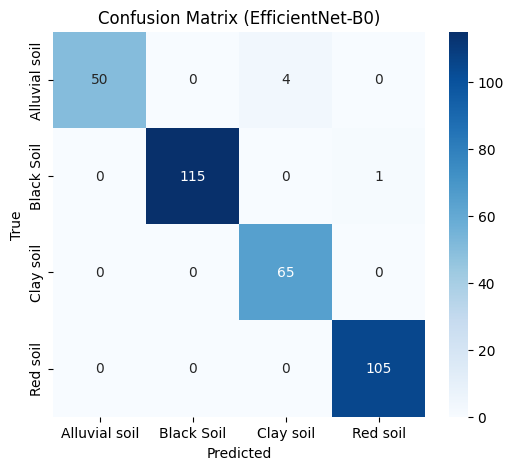

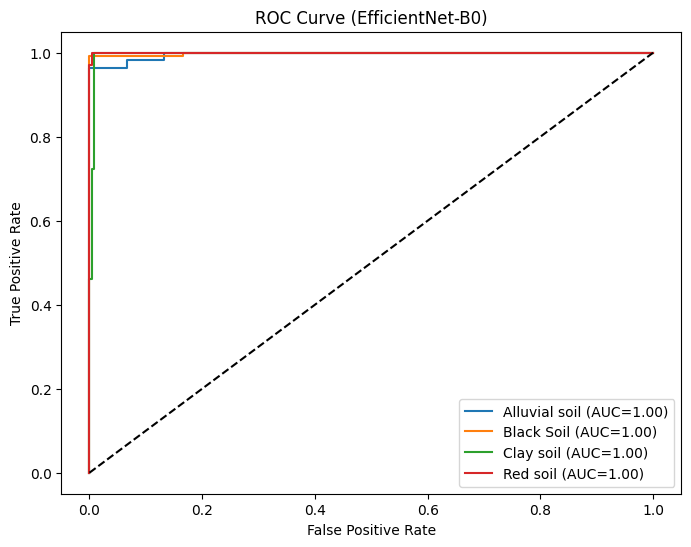

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q efficientnet_pytorch tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths

# =============================
if use_drive:
    train_dir = "/content/drive/MyDrive/datasets/Train"
    test_dir = "/content/drive/MyDrive/datasets/test"
else:
    train_dir = "/content/Dataset/Train"
    test_dir = "/content/Dataset/test"


# =============================
# Parameters
# =============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoaders
# =============================
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Model
# =============================
model = EfficientNet.from_pretrained('efficientnet-b0')  # full fine-tuning
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# =============================
# Training and validation functions
# =============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

# =============================
# Training loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# =============================
# Test Evaluation & Metrics
# =============================
model.load_state_dict(torch.load("best_model.pth"))
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.vstack(all_probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc_score = roc_auc_score(label_binarize(all_labels, classes=list(range(num_classes))), all_probs, multi_class='ovr')

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc_score:.4f}")

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (EfficientNet-B0)")
plt.savefig("confusion_matrix_efficientnet.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (EfficientNet-B0)")
plt.legend(loc="lower right")
plt.savefig("roc_curve_efficientnet.png", dpi=300)
plt.show()


ALEXNET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/datasets/Train"
test_dir = "/content/drive/MyDrive/datasets/test"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data path: /content/Dataset/Train
Test data path: /content/Dataset/test
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 125MB/s]


Epoch [1/10] Train Loss: 1.1688 Train Acc: 0.5400 Val Loss: 0.8899 Val Acc: 0.5697


Epoch [2/10] Train Loss: 0.9429 Train Acc: 0.5645 Val Loss: 0.9079 Val Acc: 0.6393


Epoch [3/10] Train Loss: 0.9346 Train Acc: 0.6209 Val Loss: 1.3468 Val Acc: 0.5984


Epoch [4/10] Train Loss: 1.1920 Train Acc: 0.5502 Val Loss: 1.0000 Val Acc: 0.6025


Epoch [5/10] Train Loss: 1.3526 Train Acc: 0.5092 Val Loss: 1.3333 Val Acc: 0.4508


Epoch [6/10] Train Loss: 1.3160 Train Acc: 0.4293 Val Loss: 1.2979 Val Acc: 0.4508


Epoch [7/10] Train Loss: 1.3079 Train Acc: 0.4293 Val Loss: 1.3016 Val Acc: 0.4508


Epoch [8/10] Train Loss: 1.3075 Train Acc: 0.4293 Val Loss: 1.2932 Val Acc: 0.4508


Epoch [9/10] Train Loss: 1.3072 Train Acc: 0.4293 Val Loss: 1.3008 Val Acc: 0.4508


Epoch [10/10] Train Loss: 1.3096 Train Acc: 0.4293 Val Loss: 1.2971 Val Acc: 0.4508
Training complete.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.35      0.83      0.49        54
   Black Soil       0.86      0.51      0.64       116
    Clay soil       0.00      0.00      0.00        65
     Red soil       0.71      0.97      0.82       105

     accuracy                           0.61       340
    macro avg       0.48      0.58      0.49       340
 weighted avg       0.57      0.61      0.55       340

Test Accuracy: 0.6059, Precision: 0.5678, Recall: 0.6059, F1: 0.5502, MAE: 0.6735, AUC: 0.8970


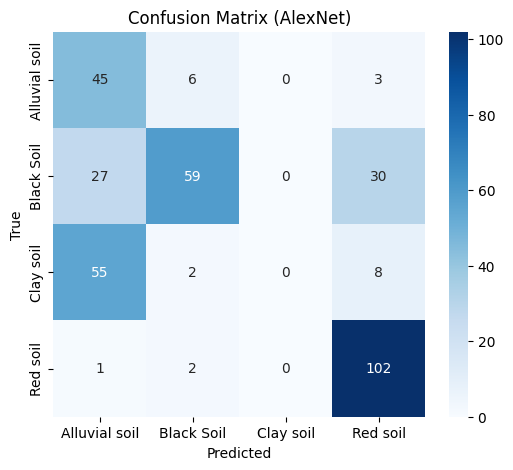

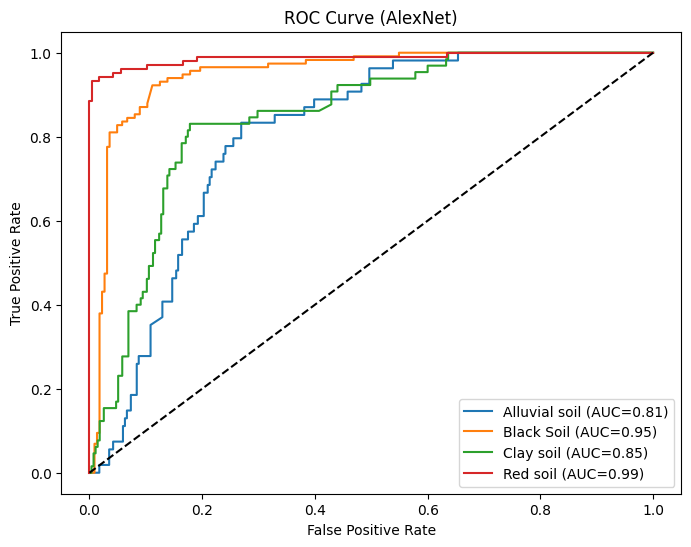

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from google.colab import drive

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
use_drive = True  # Set True if using Google Drive

if use_drive:
    drive.mount('/content/drive')
    drive_train_dir = "/content/drive/MyDrive/datasets/Train"
    drive_test_dir = "/content/drive/MyDrive/datasets/test"
    local_train_dir = "/content/Dataset/Train"
    local_test_dir = "/content/Dataset/test"

    # Copy data from Drive to Colab local storage if not already present
    if not os.path.exists(local_train_dir):
        shutil.copytree(drive_train_dir, local_train_dir)
    if not os.path.exists(local_test_dir):
        shutil.copytree(drive_test_dir, local_test_dir)

    train_dir = local_train_dir
    test_dir = local_test_dir
else:
    train_dir = "/content/Dataset/Train"
    test_dir = "/content/Dataset/test"

print("Training data path:", train_dir)
print("Test data path:", test_dir)

# =============================
# Parameters
# =============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoaders
# =============================
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Model: AlexNet
# =============================
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)  # pretrained on ImageNet
in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # full fine-tuning

# =============================
# Training and validation functions
# =============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

# =============================
# Training loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# =============================
# Test Evaluation & Metrics
# =============================
model.load_state_dict(torch.load("best_model.pth"))
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.vstack(all_probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc_score = roc_auc_score(label_binarize(all_labels, classes=list(range(num_classes))), all_probs, multi_class='ovr')

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc_score:.4f}")

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (AlexNet)")
plt.savefig("confusion_matrix_alexnet.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AlexNet)")
plt.legend(loc="lower right")
plt.savefig("roc_curve_alexnet.png", dpi=300)
plt.show()


MOBILNRY

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data path: /content/Dataset/Train
Test data path: /content/Dataset/test
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 58.7MB/s]


Epoch [1/10] Train Loss: 0.4643 Train Acc: 0.8402 Val Loss: 0.2837 Val Acc: 0.9139


Epoch [2/10] Train Loss: 0.2337 Train Acc: 0.9406 Val Loss: 0.2514 Val Acc: 0.9303


Epoch [3/10] Train Loss: 0.1735 Train Acc: 0.9498 Val Loss: 0.1220 Val Acc: 0.9672


Epoch [4/10] Train Loss: 0.0892 Train Acc: 0.9682 Val Loss: 0.1593 Val Acc: 0.9631


Epoch [5/10] Train Loss: 0.0921 Train Acc: 0.9723 Val Loss: 0.1506 Val Acc: 0.9590


Epoch [6/10] Train Loss: 0.1049 Train Acc: 0.9672 Val Loss: 0.1156 Val Acc: 0.9631


Epoch [7/10] Train Loss: 0.1101 Train Acc: 0.9672 Val Loss: 0.2074 Val Acc: 0.9549


Epoch [8/10] Train Loss: 0.1171 Train Acc: 0.9785 Val Loss: 0.0977 Val Acc: 0.9672


Epoch [9/10] Train Loss: 0.0707 Train Acc: 0.9795 Val Loss: 0.4214 Val Acc: 0.9508


Epoch [10/10] Train Loss: 0.1079 Train Acc: 0.9682 Val Loss: 0.2166 Val Acc: 0.9221
Training complete.

Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.96      0.89      0.92        54
   Black Soil       0.97      1.00      0.99       116
    Clay soil       0.97      0.98      0.98        65
     Red soil       0.97      0.97      0.97       105

     accuracy                           0.97       340
    macro avg       0.97      0.96      0.96       340
 weighted avg       0.97      0.97      0.97       340

Test Accuracy: 0.9706, Precision: 0.9704, Recall: 0.9706, F1: 0.9702, MAE: 0.0618, AUC: 0.9962


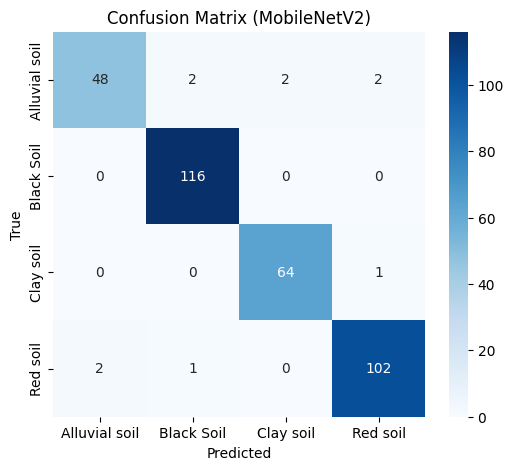

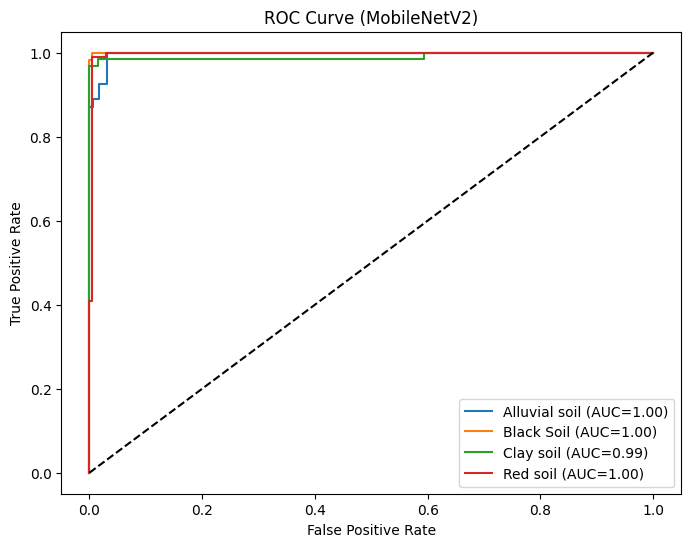

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from google.colab import drive

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
use_drive = True  # Set True if using Google Drive

if use_drive:
    drive.mount('/content/drive')
    drive_train_dir = "/content/drive/MyDrive/datasets/Train"
    drive_test_dir = "/content/drive/MyDrive/datasets/test"
    local_train_dir = "/content/Dataset/Train"
    local_test_dir = "/content/Dataset/test"

    # Copy data from Drive to Colab local storage if not already present
    if not os.path.exists(local_train_dir):
        shutil.copytree(drive_train_dir, local_train_dir)
    if not os.path.exists(local_test_dir):
        shutil.copytree(drive_test_dir, local_test_dir)

    train_dir = local_train_dir
    test_dir = local_test_dir
else:
    train_dir = "/content/Dataset/Train"
    test_dir = "/content/Dataset/test"

print("Training data path:", train_dir)
print("Test data path:", test_dir)

# =============================
# Parameters
# =============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoaders
# =============================
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Model: MobileNetV2
# =============================
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)  # pretrained
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)  # adjust output
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # full fine-tuning

# =============================
# Training and validation functions
# =============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

# =============================
# Training loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# =============================
# Test Evaluation & Metrics
# =============================
model.load_state_dict(torch.load("best_model.pth"))
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.vstack(all_probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc_score = roc_auc_score(label_binarize(all_labels, classes=list(range(num_classes))), all_probs, multi_class='ovr')

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc_score:.4f}")

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (MobileNetV2)")
plt.savefig("confusion_matrix_mobilenet.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MobileNetV2)")
plt.legend(loc="lower right")
plt.savefig("roc_curve_mobilenet.png", dpi=300)
plt.show()


R

Resnet

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data path: /content/Dataset/Train
Test data path: /content/Dataset/test
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


Epoch [1/10] Train Loss: 0.5235 Train Acc: 0.8309 Val Loss: 0.3918 Val Acc: 0.8852


Epoch [2/10] Train Loss: 0.2991 Train Acc: 0.8996 Val Loss: 0.9143 Val Acc: 0.8811


Epoch [3/10] Train Loss: 0.2834 Train Acc: 0.9191 Val Loss: 2.3181 Val Acc: 0.7910


Epoch [4/10] Train Loss: 0.2856 Train Acc: 0.9252 Val Loss: 0.2040 Val Acc: 0.9303


Epoch [5/10] Train Loss: 0.1895 Train Acc: 0.9436 Val Loss: 0.4381 Val Acc: 0.8730


Epoch [6/10] Train Loss: 0.1183 Train Acc: 0.9590 Val Loss: 0.2232 Val Acc: 0.9303


Epoch [7/10] Train Loss: 0.1534 Train Acc: 0.9580 Val Loss: 0.1734 Val Acc: 0.9344


Epoch [8/10] Train Loss: 0.1440 Train Acc: 0.9621 Val Loss: 0.1788 Val Acc: 0.9467


Epoch [9/10] Train Loss: 0.0486 Train Acc: 0.9877 Val Loss: 0.2069 Val Acc: 0.9549


Epoch [10/10] Train Loss: 0.0567 Train Acc: 0.9846 Val Loss: 0.1550 Val Acc: 0.9508
Training complete.

Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.91      0.93      0.92        54
   Black Soil       1.00      0.97      0.98       116
    Clay soil       0.94      0.97      0.95        65
     Red soil       0.99      1.00      1.00       105

     accuracy                           0.97       340
    macro avg       0.96      0.97      0.96       340
 weighted avg       0.97      0.97      0.97       340

Test Accuracy: 0.9706, Precision: 0.9712, Recall: 0.9706, F1: 0.9707, MAE: 0.0500, AUC: 0.9929


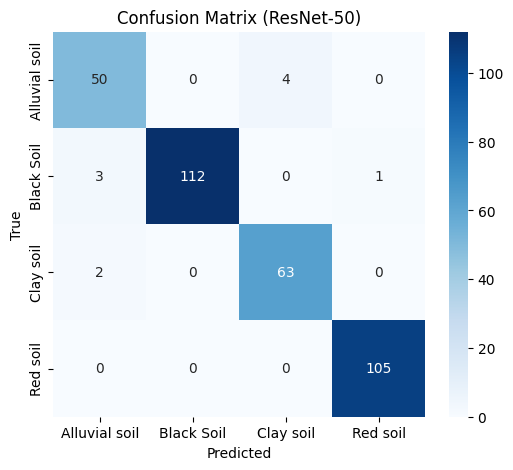

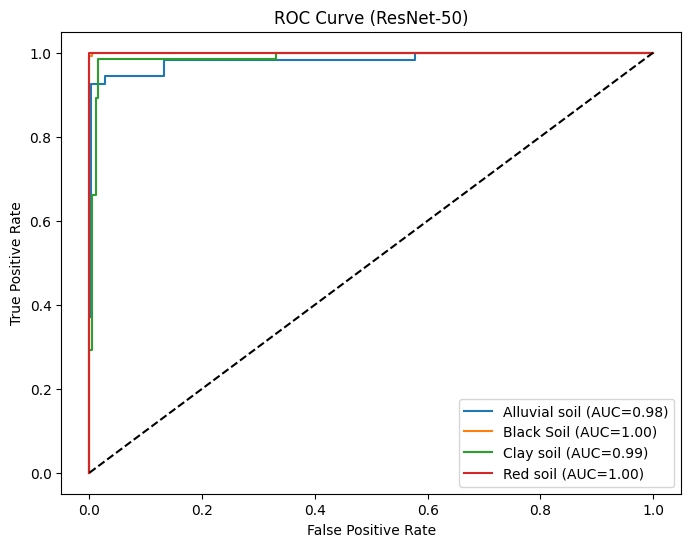

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from google.colab import drive

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
use_drive = True  # Set True if using Google Drive

if use_drive:
    drive.mount('/content/drive')
    drive_train_dir = "/content/drive/MyDrive/datasets/Train"
    drive_test_dir = "/content/drive/MyDrive/datasets/test"
    local_train_dir = "/content/Dataset/Train"
    local_test_dir = "/content/Dataset/test"

    if not os.path.exists(local_train_dir):
        shutil.copytree(drive_train_dir, local_train_dir)
    if not os.path.exists(local_test_dir):
        shutil.copytree(drive_test_dir, local_test_dir)

    train_dir = local_train_dir
    test_dir = local_test_dir
else:
    train_dir = "/content/Dataset/Train"
    test_dir = "/content/Dataset/test"

print("Training data path:", train_dir)
print("Test data path:", test_dir)

# =============================
# Parameters
# =============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoaders
# =============================
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Model: ResNet-50
# =============================
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # pretrained
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # adjust output
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # full fine-tuning

# =============================
# Training and validation functions
# =============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

# =============================
# Training loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# =============================
# Test Evaluation & Metrics
# =============================
model.load_state_dict(torch.load("best_model.pth"))
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.vstack(all_probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc_score = roc_auc_score(label_binarize(all_labels, classes=list(range(num_classes))), all_probs, multi_class='ovr')

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc_score:.4f}")

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ResNet-50)")
plt.savefig("confusion_matrix_resnet50.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet-50)")
plt.legend(loc="lower right")
plt.savefig("roc_curve_resnet50.png", dpi=300)
plt.show()


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data path: /content/Dataset/Train
Test data path: /content/Dataset/test
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 110MB/s]


Epoch [1/10] Train Loss: 0.4174 Train Acc: 0.8504 Val Loss: 0.6561 Val Acc: 0.8074


Epoch [2/10] Train Loss: 0.2489 Train Acc: 0.9191 Val Loss: 0.4868 Val Acc: 0.8566


Epoch [3/10] Train Loss: 0.2185 Train Acc: 0.9242 Val Loss: 0.2795 Val Acc: 0.8975


Epoch [4/10] Train Loss: 0.2018 Train Acc: 0.9283 Val Loss: 0.5158 Val Acc: 0.8320


Epoch [5/10] Train Loss: 0.1547 Train Acc: 0.9467 Val Loss: 0.1746 Val Acc: 0.9426


Epoch [6/10] Train Loss: 0.1472 Train Acc: 0.9559 Val Loss: 0.3843 Val Acc: 0.9057


Epoch [7/10] Train Loss: 0.1527 Train Acc: 0.9559 Val Loss: 0.1389 Val Acc: 0.9303


Epoch [8/10] Train Loss: 0.1068 Train Acc: 0.9652 Val Loss: 0.0946 Val Acc: 0.9754


Epoch [9/10] Train Loss: 0.0672 Train Acc: 0.9775 Val Loss: 0.1481 Val Acc: 0.9631


Epoch [10/10] Train Loss: 0.0583 Train Acc: 0.9846 Val Loss: 0.1017 Val Acc: 0.9713
Training complete.



Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.98      0.94      0.96        54
   Black Soil       1.00      0.98      0.99       116
    Clay soil       0.96      1.00      0.98        65
     Red soil       0.99      1.00      1.00       105

     accuracy                           0.99       340
    macro avg       0.98      0.98      0.98       340
 weighted avg       0.99      0.99      0.99       340

Test Accuracy: 0.9853, Precision: 0.9856, Recall: 0.9853, F1: 0.9853, MAE: 0.0265, AUC: 0.9986


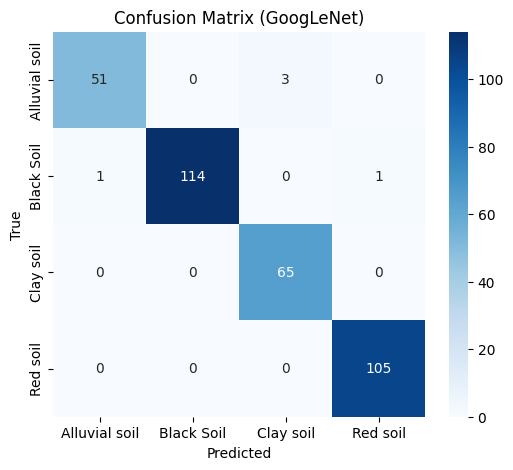

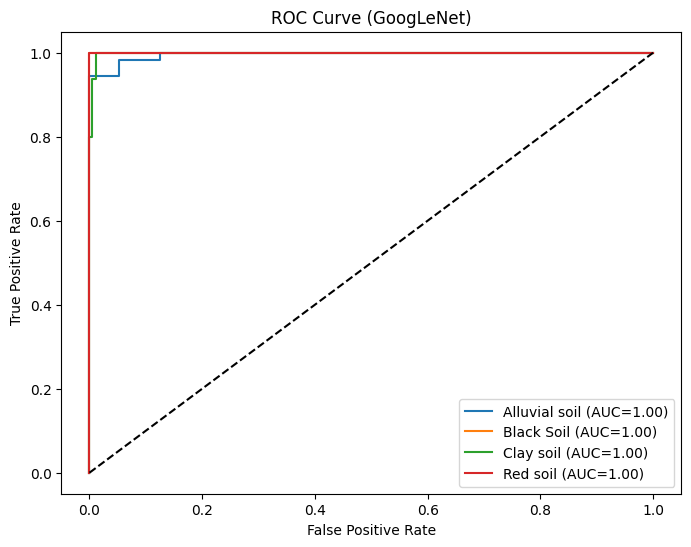

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from google.colab import drive

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
use_drive = True  # Set True if using Google Drive

if use_drive:
    drive.mount('/content/drive')
    drive_train_dir = "/content/drive/MyDrive/datasets/Train"
    drive_test_dir = "/content/drive/MyDrive/datasets/test"
    local_train_dir = "/content/Dataset/Train"
    local_test_dir = "/content/Dataset/test"

    if not os.path.exists(local_train_dir):
        shutil.copytree(drive_train_dir, local_train_dir)
    if not os.path.exists(local_test_dir):
        shutil.copytree(drive_test_dir, local_test_dir)

    train_dir = local_train_dir
    test_dir = local_test_dir
else:
    train_dir = "/content/Dataset/Train"
    test_dir = "/content/Dataset/test"

print("Training data path:", train_dir)
print("Test data path:", test_dir)

# =============================
# Parameters
# =============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoaders
# =============================
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Model: GoogLeNet
# =============================
model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)  # pretrained
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # adjust output
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # full fine-tuning

# =============================
# Training and validation functions
# =============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

# =============================
# Training loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# =============================
# Test Evaluation & Metrics
# =============================
model.load_state_dict(torch.load("best_model.pth"))
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.vstack(all_probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc_score = roc_auc_score(label_binarize(all_labels, classes=list(range(num_classes))), all_probs, multi_class='ovr')

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc_score:.4f}")

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (GoogLeNet)")
plt.savefig("confusion_matrix_googlenet.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (GoogLeNet)")
plt.legend(loc="lower right")
plt.savefig("roc_curve_googlenet.png", dpi=300)
plt.show()


Dense net 121


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data path: /content/Dataset/Train
Test data path: /content/Dataset/test
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 133MB/s]


Epoch [1/10] Train Loss: 0.5262 Train Acc: 0.8084 Val Loss: 0.7945 Val Acc: 0.8607


Epoch [2/10] Train Loss: 0.3668 Train Acc: 0.8740 Val Loss: 0.2833 Val Acc: 0.9262


Epoch [3/10] Train Loss: 0.3592 Train Acc: 0.8719 Val Loss: 0.3262 Val Acc: 0.8934


Epoch [4/10] Train Loss: 0.2517 Train Acc: 0.9109 Val Loss: 0.2160 Val Acc: 0.9344


Epoch [5/10] Train Loss: 0.1888 Train Acc: 0.9416 Val Loss: 0.1908 Val Acc: 0.9221


Epoch [6/10] Train Loss: 0.1797 Train Acc: 0.9385 Val Loss: 0.2087 Val Acc: 0.9508


Epoch [7/10] Train Loss: 0.1798 Train Acc: 0.9375 Val Loss: 0.1852 Val Acc: 0.9385


Epoch [8/10] Train Loss: 0.0887 Train Acc: 0.9703 Val Loss: 0.1281 Val Acc: 0.9590


Epoch [9/10] Train Loss: 0.1618 Train Acc: 0.9477 Val Loss: 0.2269 Val Acc: 0.9262


Epoch [10/10] Train Loss: 0.1894 Train Acc: 0.9334 Val Loss: 0.2247 Val Acc: 0.9467
Training complete.

Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.81      0.94      0.87        54
   Black Soil       1.00      0.95      0.97       116
    Clay soil       0.94      0.89      0.91        65
     Red soil       1.00      1.00      1.00       105

     accuracy                           0.95       340
    macro avg       0.94      0.95      0.94       340
 weighted avg       0.96      0.95      0.95       340

Test Accuracy: 0.9529, Precision: 0.9574, Recall: 0.9529, F1: 0.9540, MAE: 0.0765, AUC: 0.9958


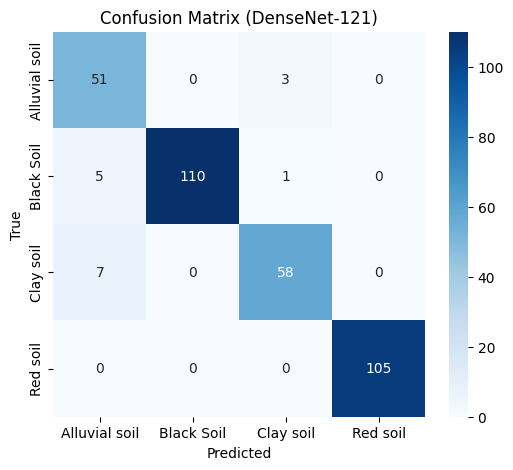

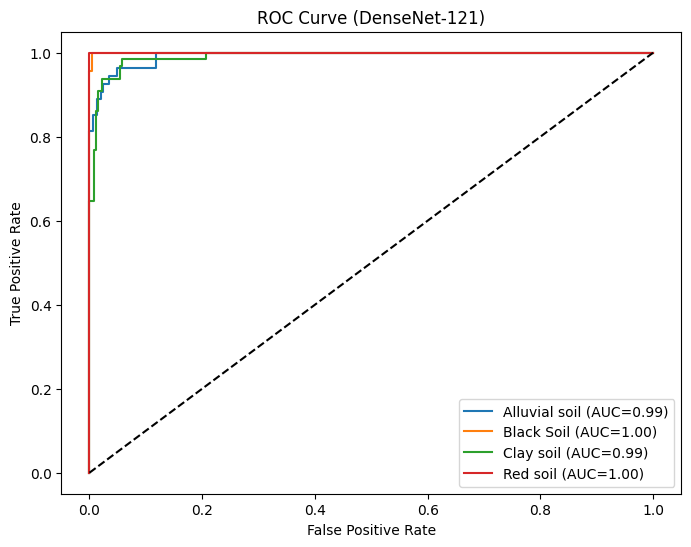

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from google.colab import drive

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
use_drive = True  # Set True if using Google Drive

if use_drive:
    drive.mount('/content/drive')
    drive_train_dir = "/content/drive/MyDrive/datasets/Train"
    drive_test_dir = "/content/drive/MyDrive/datasets/test"
    local_train_dir = "/content/Dataset/Train"
    local_test_dir = "/content/Dataset/test"

    if not os.path.exists(local_train_dir):
        shutil.copytree(drive_train_dir, local_train_dir)
    if not os.path.exists(local_test_dir):
        shutil.copytree(drive_test_dir, local_test_dir)

    train_dir = local_train_dir
    test_dir = local_test_dir
else:
    train_dir = "/content/Dataset/Train"
    test_dir = "/content/Dataset/test"

print("Training data path:", train_dir)
print("Test data path:", test_dir)

# =============================
# Parameters
# =============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoaders
# =============================
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Model: DenseNet-121
# =============================
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)  # pretrained
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)  # adjust output
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # full fine-tuning

# =============================
# Training and validation functions
# =============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

# =============================
# Training loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# =============================
# Test Evaluation & Metrics
# =============================
model.load_state_dict(torch.load("best_model.pth"))
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.vstack(all_probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc_score = roc_auc_score(label_binarize(all_labels, classes=list(range(num_classes))), all_probs, multi_class='ovr')

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc_score:.4f}")

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (DenseNet-121)")
plt.savefig("confusion_matrix_densenet.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (DenseNet-121)")
plt.legend(loc="lower right")
plt.savefig("roc_curve_densenet.png", dpi=300)
plt.show()


shufflenet

Using device: cuda


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data path: /content/Dataset/Train
Test data path: /content/Dataset/test
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


100%|██████████| 8.79M/8.79M [00:00<00:00, 65.0MB/s]


Epoch [1/10] Train Loss: 0.8851 Train Acc: 0.8166 Val Loss: 0.3397 Val Acc: 0.8934


Epoch [2/10] Train Loss: 0.3371 Train Acc: 0.9037 Val Loss: 0.1872 Val Acc: 0.9262


Epoch [3/10] Train Loss: 0.1960 Train Acc: 0.9375 Val Loss: 0.1284 Val Acc: 0.9590


Epoch [4/10] Train Loss: 0.1513 Train Acc: 0.9549 Val Loss: 0.1231 Val Acc: 0.9631


Epoch [5/10] Train Loss: 0.1009 Train Acc: 0.9764 Val Loss: 0.1045 Val Acc: 0.9672


Epoch [6/10] Train Loss: 0.0599 Train Acc: 0.9857 Val Loss: 0.0780 Val Acc: 0.9795


Epoch [7/10] Train Loss: 0.0464 Train Acc: 0.9857 Val Loss: 0.0861 Val Acc: 0.9754


Epoch [8/10] Train Loss: 0.0417 Train Acc: 0.9908 Val Loss: 0.1192 Val Acc: 0.9672


Epoch [9/10] Train Loss: 0.0354 Train Acc: 0.9918 Val Loss: 0.1874 Val Acc: 0.9631


Epoch [10/10] Train Loss: 0.0989 Train Acc: 0.9775 Val Loss: 0.2264 Val Acc: 0.9549
Training complete.



Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.98      0.98      0.98        54
   Black Soil       1.00      0.99      1.00       116
    Clay soil       0.98      1.00      0.99        65
     Red soil       1.00      1.00      1.00       105

     accuracy                           0.99       340
    macro avg       0.99      0.99      0.99       340
 weighted avg       0.99      0.99      0.99       340

Test Accuracy: 0.9941, Precision: 0.9942, Recall: 0.9941, F1: 0.9941, MAE: 0.0088, AUC: 0.9995


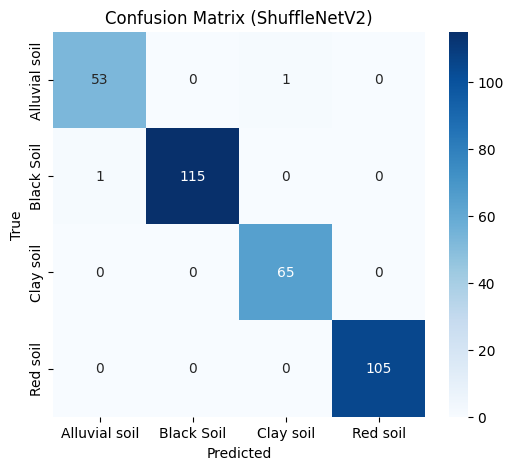

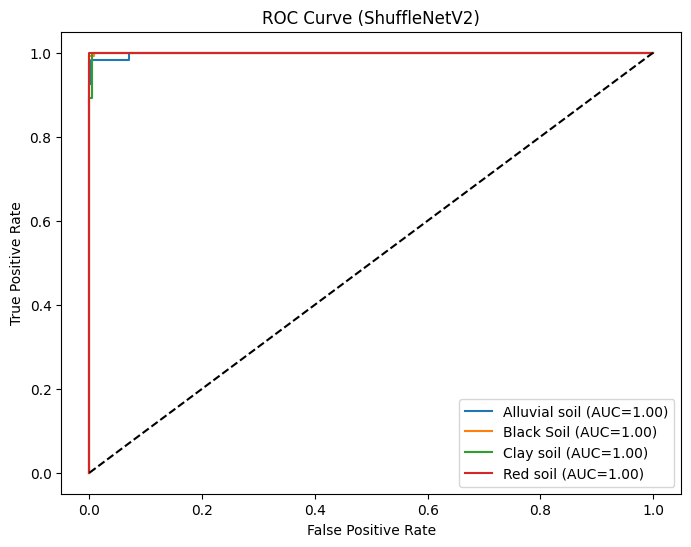

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from google.colab import drive

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
use_drive = True  # Set True if using Google Drive

if use_drive:
    drive.mount('/content/drive')
    drive_train_dir = "/content/drive/MyDrive/datasets/Train"
    drive_test_dir = "/content/drive/MyDrive/datasets/test"
    local_train_dir = "/content/Dataset/Train"
    local_test_dir = "/content/Dataset/test"

    if not os.path.exists(local_train_dir):
        shutil.copytree(drive_train_dir, local_train_dir)
    if not os.path.exists(local_test_dir):
        shutil.copytree(drive_test_dir, local_test_dir)

    train_dir = local_train_dir
    test_dir = local_test_dir
else:
    train_dir = "/content/Dataset/Train"
    test_dir = "/content/Dataset/test"

print("Training data path:", train_dir)
print("Test data path:", test_dir)

# =============================
# Parameters
# =============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoaders
# =============================
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Model: ShuffleNetV2
# =============================
model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)  # pretrained
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # adjust output
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # full fine-tuning

# =============================
# Training and validation functions
# =============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

# =============================
# Training loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# =============================
# Test Evaluation & Metrics
# =============================
model.load_state_dict(torch.load("best_model.pth"))
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.vstack(all_probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc_score = roc_auc_score(label_binarize(all_labels, classes=list(range(num_classes))), all_probs, multi_class='ovr')

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc_score:.4f}")

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ShuffleNetV2)")
plt.savefig("confusion_matrix_shufflenet.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ShuffleNetV2)")
plt.legend(loc="lower right")
plt.savefig("roc_curve_shufflenet.png", dpi=300)
plt.show()


squeezent

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data path: /content/Dataset/Train
Test data path: /content/Dataset/test
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 88.1MB/s]


Epoch [1/10] Train Loss: 0.7693 Train Acc: 0.7070 Val Loss: 0.5901 Val Acc: 0.8156


Epoch [2/10] Train Loss: 0.3966 Train Acc: 0.8514 Val Loss: 0.5213 Val Acc: 0.7992


Epoch [3/10] Train Loss: 0.4305 Train Acc: 0.8504 Val Loss: 0.3247 Val Acc: 0.8730


Epoch [4/10] Train Loss: 0.3264 Train Acc: 0.8934 Val Loss: 0.4091 Val Acc: 0.8443


Epoch [5/10] Train Loss: 0.2854 Train Acc: 0.8975 Val Loss: 0.3691 Val Acc: 0.8525


Epoch [6/10] Train Loss: 0.2307 Train Acc: 0.9221 Val Loss: 0.2721 Val Acc: 0.9139


Epoch [7/10] Train Loss: 0.2021 Train Acc: 0.9406 Val Loss: 0.9702 Val Acc: 0.7623


Epoch [8/10] Train Loss: 0.4180 Train Acc: 0.8678 Val Loss: 0.3516 Val Acc: 0.8811


Epoch [9/10] Train Loss: 0.2628 Train Acc: 0.9170 Val Loss: 0.3561 Val Acc: 0.8811


Epoch [10/10] Train Loss: 0.2280 Train Acc: 0.9293 Val Loss: 0.2648 Val Acc: 0.9139
Training complete.



Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.85      0.72      0.78        54
   Black Soil       0.97      0.98      0.97       116
    Clay soil       0.84      0.89      0.87        65
     Red soil       0.98      1.00      0.99       105

     accuracy                           0.93       340
    macro avg       0.91      0.90      0.90       340
 weighted avg       0.93      0.93      0.93       340

Test Accuracy: 0.9294, Precision: 0.9280, Recall: 0.9294, F1: 0.9277, MAE: 0.1294, AUC: 0.9870


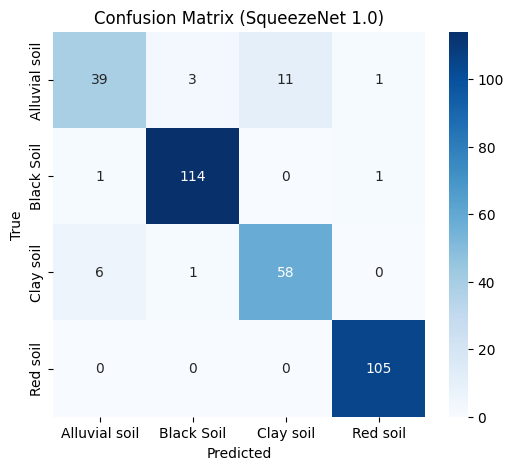

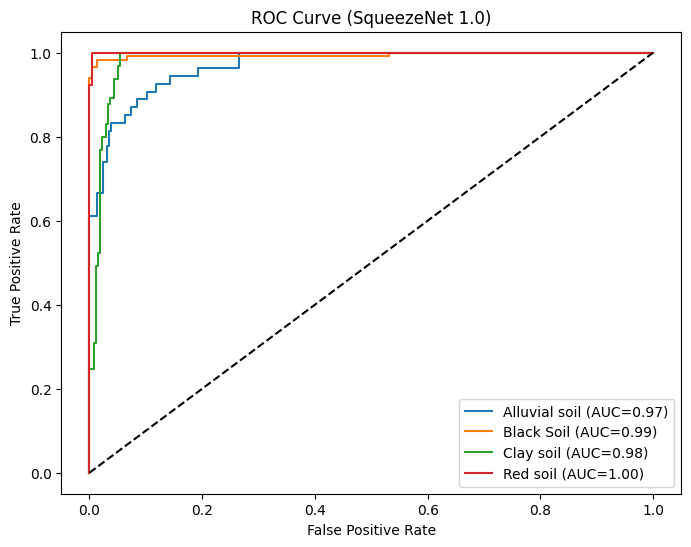

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from google.colab import drive

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
use_drive = True  # Set True if using Google Drive

if use_drive:
    drive.mount('/content/drive')
    drive_train_dir = "/content/drive/MyDrive/datasets/Train"
    drive_test_dir = "/content/drive/MyDrive/datasets/test"
    local_train_dir = "/content/Dataset/Train"
    local_test_dir = "/content/Dataset/test"

    if not os.path.exists(local_train_dir):
        shutil.copytree(drive_train_dir, local_train_dir)
    if not os.path.exists(local_test_dir):
        shutil.copytree(drive_test_dir, local_test_dir)

    train_dir = local_train_dir
    test_dir = local_test_dir
else:
    train_dir = "/content/Dataset/Train"
    test_dir = "/content/Dataset/test"

print("Training data path:", train_dir)
print("Test data path:", test_dir)

# =============================
# Parameters
# =============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoaders
# =============================
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Model: SqueezeNet 1.0
# =============================
model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)  # pretrained
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1))  # adjust output
model.num_classes = num_classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # full fine-tuning

# =============================
# Training and validation functions
# =============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.view(outputs.size(0), num_classes)  # reshape for loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), num_classes)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

# =============================
# Training loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# =============================
# Test Evaluation & Metrics
# =============================
model.load_state_dict(torch.load("best_model.pth"))
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        outputs = outputs.view(outputs.size(0), num_classes)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.vstack(all_probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc_score = roc_auc_score(label_binarize(all_labels, classes=list(range(num_classes))), all_probs, multi_class='ovr')

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc_score:.4f}")

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (SqueezeNet 1.0)")
plt.savefig("confusion_matrix_squeezenet.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SqueezeNet 1.0)")
plt.legend(loc="lower right")
plt.savefig("roc_curve_squeezenet.png", dpi=300)
plt.show()


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data path: /content/Dataset/Train
Test data path: /content/Dataset/test
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 54.9MB/s]


Epoch [1/10] Train Loss: 1.9854 Train Acc: 0.3473 Val Loss: 1.3077 Val Acc: 0.4508


Epoch [2/10] Train Loss: 1.1950 Train Acc: 0.4928 Val Loss: 0.9497 Val Acc: 0.5697


Epoch [3/10] Train Loss: 1.0342 Train Acc: 0.5543 Val Loss: 0.8511 Val Acc: 0.6762


Epoch [4/10] Train Loss: 0.7101 Train Acc: 0.6793 Val Loss: 0.6482 Val Acc: 0.7459


Epoch [5/10] Train Loss: 1.3524 Train Acc: 0.4805 Val Loss: 1.6267 Val Acc: 0.5820


Epoch [6/10] Train Loss: 1.6020 Train Acc: 0.3822 Val Loss: 1.3452 Val Acc: 0.4508


Epoch [7/10] Train Loss: 1.3498 Train Acc: 0.3975 Val Loss: 1.3647 Val Acc: 0.4508


Epoch [8/10] Train Loss: 1.3146 Train Acc: 0.3945 Val Loss: 1.3726 Val Acc: 0.4508


Epoch [9/10] Train Loss: 1.3626 Train Acc: 0.4242 Val Loss: 1.2775 Val Acc: 0.4508


Epoch [10/10] Train Loss: 1.2613 Train Acc: 0.4314 Val Loss: 1.0168 Val Acc: 0.5410
Training complete.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Classification Report:
                precision    recall  f1-score   support

Alluvial soil       0.40      0.93      0.56        54
   Black Soil       0.92      0.85      0.88       116
    Clay soil       0.00      0.00      0.00        65
     Red soil       0.91      0.92      0.92       105

     accuracy                           0.72       340
    macro avg       0.56      0.68      0.59       340
 weighted avg       0.66      0.72      0.67       340

Test Accuracy: 0.7235, Precision: 0.6562, Recall: 0.7235, F1: 0.6729, MAE: 0.5294, AUC: 0.9289


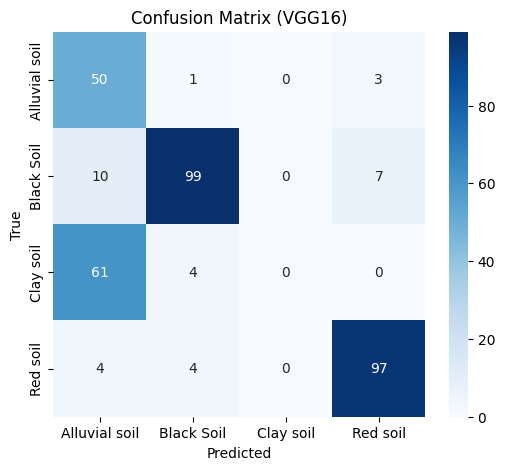

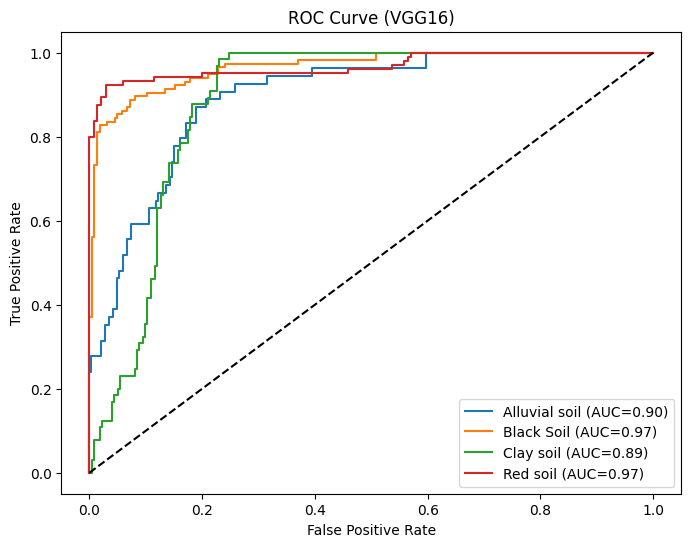

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from google.colab import drive

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
use_drive = True  # Set True if using Google Drive

if use_drive:
    drive.mount('/content/drive')
    drive_train_dir = "/content/drive/MyDrive/datasets/Train"
    drive_test_dir = "/content/drive/MyDrive/datasets/test"
    local_train_dir = "/content/Dataset/Train"
    local_test_dir = "/content/Dataset/test"

    if not os.path.exists(local_train_dir):
        shutil.copytree(drive_train_dir, local_train_dir)
    if not os.path.exists(local_test_dir):
        shutil.copytree(drive_test_dir, local_test_dir)

    train_dir = local_train_dir
    test_dir = local_test_dir
else:
    train_dir = "/content/Dataset/Train"
    test_dir = "/content/Dataset/test"

print("Training data path:", train_dir)
print("Test data path:", test_dir)

# =============================
# Parameters
# =============================
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
validation_split = 0.2
random_seed = 42

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
dataset_size = len(full_train_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

torch.manual_seed(random_seed)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoaders
# =============================
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Model: VGG16
# =============================
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)  # pretrained
in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features, num_classes)  # adjust output
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # full fine-tuning

# =============================
# Training and validation functions
# =============================
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

def evaluate(model, dataloader, criterion, device, epoch=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} Validation" if epoch is not None else "Testing", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss/total, acc=correct/total)
    return running_loss/total, correct/total

# =============================
# Training loop
# =============================
best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training complete.")

# =============================
# Test Evaluation & Metrics
# =============================
model.load_state_dict(torch.load("best_model.pth"))
all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.vstack(all_probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mae = mean_absolute_error(all_labels, all_preds)
auc_score = roc_auc_score(label_binarize(all_labels, classes=list(range(num_classes))), all_probs, multi_class='ovr')

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))
print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, MAE: {mae:.4f}, AUC: {auc_score:.4f}")

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (VGG16)")
plt.savefig("confusion_matrix_vgg16.png", dpi=300)
plt.show()

# =============================
# ROC Curve
# =============================
plt.figure(figsize=(8,6))
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{full_train_dataset.classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (VGG16)")
plt.legend(loc="lower right")
plt.savefig("roc_curve_vgg16.png", dpi=300)
plt.show()


ROC curve of all model

Using device: cuda
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
Loaded pretrained weights for efficientnet-b0


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

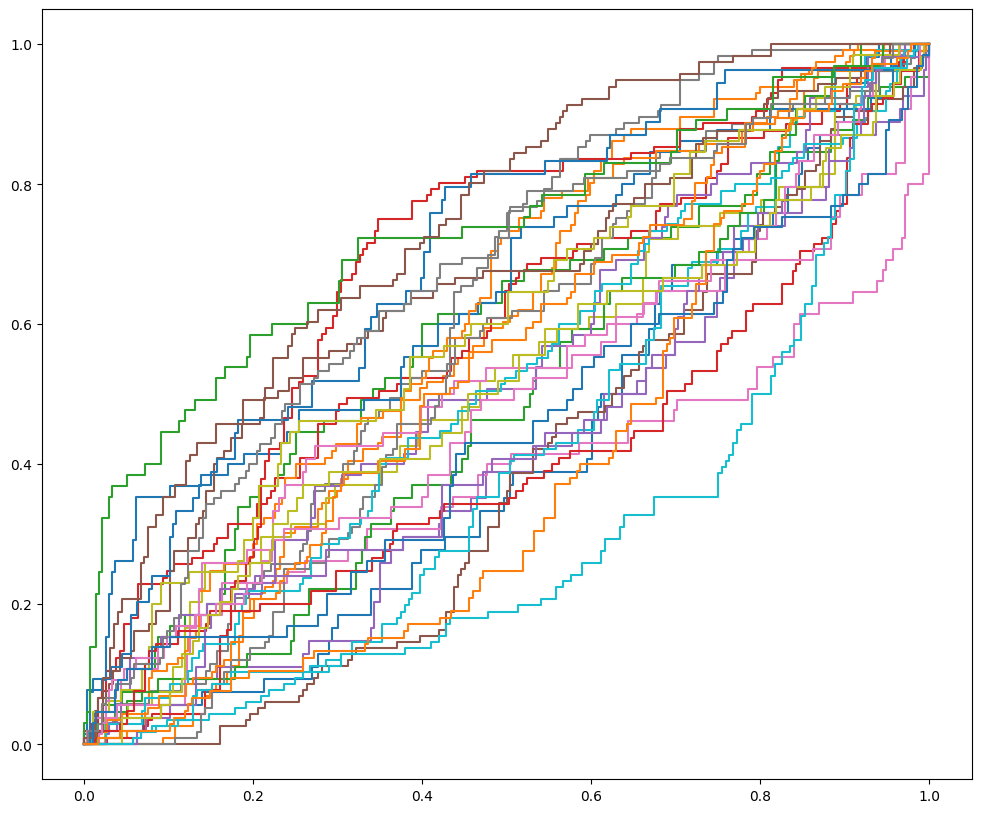

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q torchvision tqdm scikit-learn matplotlib seaborn efficientnet_pytorch

# =============================
# Imports
# =============================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# =============================
# Parameters
# =============================
batch_size = 32

# =============================
# Data transforms
# =============================
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Load datasets
# =============================
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
num_classes = len(test_dataset.classes)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Classes:", test_dataset.classes)

# =============================
# Function to initialize model
# =============================
def get_model(name, num_classes):
    if name == "AlexNet":
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "MobileNet":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "ResNet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "DenseNet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "VGG16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "EfficientNet":
        model = EfficientNet.from_pretrained('efficientnet-b0')
        model._fc = nn.Linear(model._fc.in_features, num_classes)
    elif name == "GoogLeNet":
        model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "ShuffleNet":
        model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "SqueezeNet":
        model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    else:
        raise ValueError("Model not supported")

    return model.to(device)

# =============================
# Evaluate function
# =============================
def get_model_probs(model, dataloader, model_name):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if model_name == "SqueezeNet":
                outputs = outputs.mean([2, 3])  # Global Average Pool for SqueezeNet
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.vstack(all_probs), np.hstack(all_labels)

# =============================
# List of models
# =============================
model_names = ["AlexNet","MobileNet","ResNet50","DenseNet121","VGG16","EfficientNet","GoogLeNet","ShuffleNet","SqueezeNet"]

# =============================
# ROC Comparison Plot
# =============================
plt.figure(figsize=(12,10))
y_bin = None
for name in model_names:
    model = get_model(name, num_classes)
    # Load pretrained weights if you have saved them after training
    # model.load_state_dict(torch.load(f"{name}_best.pth"))

    all_probs, all_labels = get_model_probs(model, test_loader, name)
    if y_bin is None:
        y_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} Class {i} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of All Models")
plt.legend(loc="lower right", fontsize=7)
plt.show()


Using device: cuda
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
Processing AlexNet...
Processing MobileNet...
Processing ResNet50...
Processing DenseNet121...
Processing VGG16...
Processing EfficientNet...
Loaded pretrained weights for efficientnet-b0
Processing GoogLeNet...
Processing ShuffleNet...
Processing SqueezeNet...


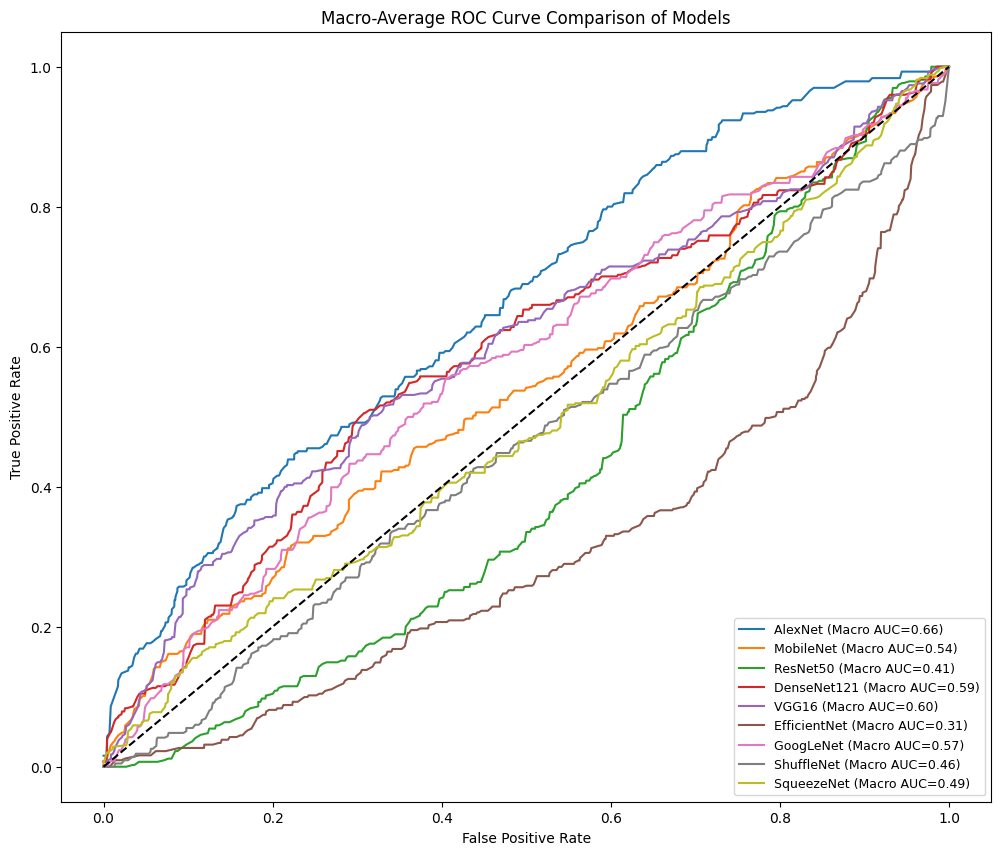

In [ ]:
# =============================
# Install packages
# =============================
!pip install -q torchvision tqdm scikit-learn matplotlib seaborn efficientnet_pytorch

# =============================
# Imports
# =============================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/test"

# =============================
# Parameters
# =============================
batch_size = 32

# =============================
# Data transforms
# =============================
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Load test dataset
# =============================
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
num_classes = len(test_dataset.classes)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Classes:", test_dataset.classes)

# =============================
# Function to initialize models
# =============================
def get_model(name, num_classes):
    if name == "AlexNet":
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "MobileNet":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "ResNet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "DenseNet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "VGG16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "EfficientNet":
        model = EfficientNet.from_pretrained('efficientnet-b0')
        model._fc = nn.Linear(model._fc.in_features, num_classes)
    elif name == "GoogLeNet":
        model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "ShuffleNet":
        model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "SqueezeNet":
        model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    else:
        raise ValueError("Model not supported")

    return model.to(device)

# =============================
# Function to get predictions and probabilities
# =============================
def get_model_probs(model, dataloader, model_name):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # SqueezeNet output shape check
            if model_name == "SqueezeNet" and outputs.dim() == 4:
                outputs = outputs.mean([2, 3])

            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.vstack(all_probs), np.hstack(all_labels)

# =============================
# List of models
# =============================
model_names = ["AlexNet","MobileNet","ResNet50","DenseNet121","VGG16",
               "EfficientNet","GoogLeNet","ShuffleNet","SqueezeNet"]

# =============================
# Prepare one-hot labels for ROC
# =============================
y_true_bin = label_binarize([label for _, label in test_dataset], classes=list(range(num_classes)))

# =============================
# Plot Macro-Average ROC
# =============================
plt.figure(figsize=(12,10))
for name in model_names:
    print(f"Processing {name}...")
    model = get_model(name, num_classes)

    # Load trained weights if available
    # model.load_state_dict(torch.load(f"{name}_best.pth"))

    all_probs, all_labels = get_model_probs(model, test_loader, name)

    # Macro-average ROC
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    # Interpolate and average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f"{name} (Macro AUC={macro_auc:.2f})")

plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve Comparison of Models")
plt.legend(loc="lower right", fontsize=9)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ==== Function for combined macro-average ROC ====
def plot_combined_macro_roc(models, X_test, y_test, class_names, save_path=None):
    """
    Plot one macro-average ROC curve per model.

    Parameters
    ----------
    models : dict
        Dictionary {model_name: trained_model}
    X_test : array
        Test features
    y_test : array
        True test labels
    class_names : list
        List of class names
    save_path : str or None
        If provided, saves the figure to this file (e.g., "roc_plot.png")
    """
    # Binarize labels for multi-class ROC
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(9, 7))

    for name, model in models.items():
        # Predict probability scores
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            print(f"Skipping {name}, no predict_proba or decision_function")
            continue

        # Compute ROC per class
        fpr, tpr = dict(), dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

        # Compute macro-average ROC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes

        macro_auc = auc(all_fpr, mean_tpr)

        # Plot one curve for this model
        plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (AUC = {macro_auc:.3f})")

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("Macro-Average ROC Curves (9 Models)", fontsize=14)
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


# ==== Example usage with your 9 models ====
# Replace variable names with your trained models
models = {
    "EfficientNet": efficientnet_model,
    "AlexNet": alexnet_model,
    "MobileNet": mobilenet_model,
    "VGG-16": vgg16_model,
    "ResNet-50": resnet50_model,
    "GoogLeNet": googlenet_model,
    "DenseNet-121": densenet_model,
    "ShuffleNetv2": shufflenet_model,
    "SqueezeNet": squeezenet_model
}

class_names = ["Class 0", "Class 1", "Class 2", "Class 3"]  # replace with your actual class labels

# Call function
plot_combined_macro_roc(models, X_test, y_test, class_names, save_path="roc_comparison.png")


NameError: name 'efficientnet_model' is not defined

Using device: cuda
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
Processing AlexNet...
Processing MobileNet...
Processing ResNet50...
Processing DenseNet121...
Processing VGG16...
Processing EfficientNet...
Loaded pretrained weights for efficientnet-b0
Processing GoogLeNet...
Processing ShuffleNet...
Processing SqueezeNet...


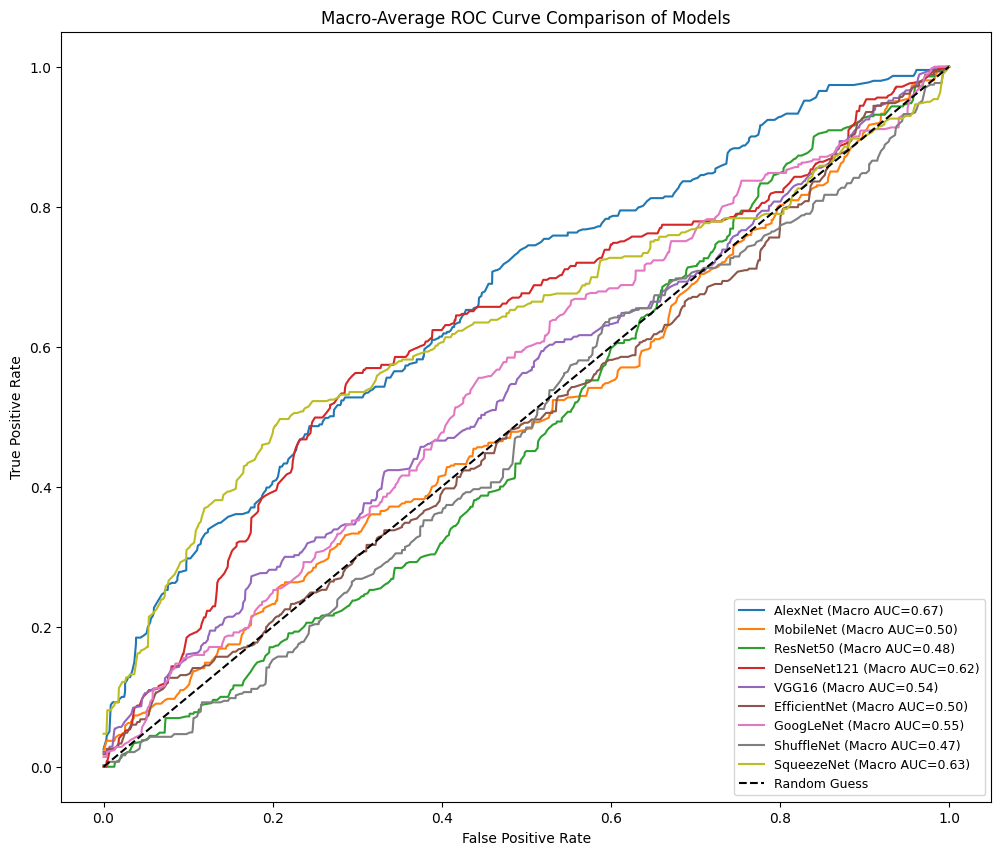

In [ ]:
# =============================
# Imports
# =============================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset
# =============================
test_dir = "/content/Dataset/test"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
num_classes = len(test_dataset.classes)
class_names = test_dataset.classes
print("Classes:", class_names)

# =============================
# Model initialization function
# =============================
def get_model(name, num_classes):
    if name == "AlexNet":
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "MobileNet":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "ResNet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "DenseNet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "VGG16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "EfficientNet":
        model = EfficientNet.from_pretrained('efficientnet-b0')
        model._fc = nn.Linear(model._fc.in_features, num_classes)
    elif name == "GoogLeNet":
        model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "ShuffleNet":
        model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "SqueezeNet":
        model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    else:
        raise ValueError("Unsupported model")
    return model.to(device)

# =============================
# Get predictions and probabilities
# =============================
def get_model_probs(model, dataloader, model_name):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if model_name == "SqueezeNet" and outputs.dim() == 4:
                outputs = outputs.mean([2, 3])  # GAP for SqueezeNet
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.vstack(all_probs), np.hstack(all_labels)

# =============================
# List of models
# =============================
model_names = ["AlexNet","MobileNet","ResNet50","DenseNet121","VGG16",
               "EfficientNet","GoogLeNet","ShuffleNet","SqueezeNet"]

# =============================
# Compute macro-average ROC
# =============================
y_true_bin = label_binarize([label for _, label in test_dataset], classes=list(range(num_classes)))

plt.figure(figsize=(12,10))

for name in model_names:
    print(f"Processing {name}...")
    model = get_model(name, num_classes)

    # Load saved weights if available
    # model.load_state_dict(torch.load(f"{name}_best.pth"))

    all_probs, all_labels = get_model_probs(model, test_loader, name)

    # Macro-average ROC
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f"{name} (Macro AUC={macro_auc:.2f})")

plt.plot([0,1],[0,1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve Comparison of Models")
plt.legend(loc="lower right", fontsize=9)
plt.show()


In [ ]:
# =============================
# Install packages
# =============================
!pip install -q tqdm seaborn scikit-learn

# =============================
# Imports
# =============================
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from google.colab import drive

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# Dataset paths
# =============================
drive.mount('/content/drive')
train_dir = "/content/drive/MyDrive/datasets/Train"
test_dir = "/content/drive/MyDrive/datasets/test"

local_train_dir = "/content/Dataset/Train"
local_test_dir = "/content/Dataset/test"
if not os.path.exists(local_train_dir):
    shutil.copytree(train_dir, local_train_dir)
if not os.path.exists(local_test_dir):
    shutil.copytree(test_dir, local_test_dir)

train_dir = local_train_dir
test_dir = local_test_dir

# =============================
# Parameters
# =============================
batch_size = 32

# =============================
# Data transforms
# =============================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =============================
# Datasets
# =============================
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
num_classes = len(full_train_dataset.classes)
print("Classes:", full_train_dataset.classes)

# =============================
# DataLoader
# =============================
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# =============================
# Helper: Get probabilities
# =============================
def get_model_probs(model, dataloader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.vstack(all_probs), np.concatenate(all_labels)

# =============================
# Define and load all models
# =============================
models_dict = {}

# 1. AlexNet
alexnet_model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, num_classes)
alexnet_model.load_state_dict(torch.load("alexnet_best.pth"))
alexnet_model = alexnet_model.to(device)
models_dict["AlexNet"] = alexnet_model

# 2. MobileNet
mobilenet_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, num_classes)
mobilenet_model.load_state_dict(torch.load("mobilenet_best.pth"))
mobilenet_model = mobilenet_model.to(device)
models_dict["MobileNet"] = mobilenet_model

# 3. ResNet50
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model.load_state_dict(torch.load("resnet50_best.pth"))
resnet_model = resnet_model.to(device)
models_dict["ResNet50"] = resnet_model

# 4. DenseNet121
densenet_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, num_classes)
densenet_model.load_state_dict(torch.load("densenet_best.pth"))
densenet_model = densenet_model.to(device)
models_dict["DenseNet121"] = densenet_model

# 5. VGG16
vgg16_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, num_classes)
vgg16_model.load_state_dict(torch.load("vgg16_best.pth"))
vgg16_model = vgg16_model.to(device)
models_dict["VGG16"] = vgg16_model

# 6. EfficientNet
efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, num_classes)
efficientnet_model.load_state_dict(torch.load("efficientnet_best.pth"))
efficientnet_model = efficientnet_model.to(device)
models_dict["EfficientNet"] = efficientnet_model

# 7. GoogLeNet
googlenet_model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.load_state_dict(torch.load("googlenet_best.pth"))
googlenet_model = googlenet_model.to(device)
models_dict["GoogLeNet"] = googlenet_model

# 8. ShuffleNet
shufflenet_model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
shufflenet_model.fc = nn.Linear(shufflenet_model.fc.in_features, num_classes)
shufflenet_model.load_state_dict(torch.load("shufflenet_best.pth"))
shufflenet_model = shufflenet_model.to(device)
models_dict["ShuffleNet"] = shufflenet_model

# 9. SqueezeNet
squeezenet_model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)
squeezenet_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1))
squeezenet_model.load_state_dict(torch.load("squeezenet_best.pth"))
squeezenet_model = squeezenet_model.to(device)
models_dict["SqueezeNet"] = squeezenet_model

# =============================
# Macro-average ROC
# =============================
plt.figure(figsize=(8,6))
auc_results = {}

for name, model in models_dict.items():
    print(f"Processing {name}...")
    all_probs, all_labels = get_model_probs(model, test_loader)
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    fpr, tpr = {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)
    auc_results[name] = macro_auc

    plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} (AUC={macro_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve (All Models)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("macro_roc_comparison.png", dpi=600)
plt.show()

# =============================
# Print AUC Table
# =============================
print("\nMacro-AUC Scores:")
for name, score in auc_results.items():
    print(f"{name:<15} {score:.4f}")


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']


FileNotFoundError: [Errno 2] No such file or directory: 'alexnet_best.pth'